<a href="https://colab.research.google.com/github/lim1004567/AICV03_SEM_3D_METROLOGY/blob/main/MMT_S_%EC%84%B1%EB%8A%A5%EA%B0%9C%EC%84%A01_%EA%B8%B0%EB%B0%98_%EC%8B%A4%ED%97%98_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 환경 설정 및 라이브러리 Import (베이스라인)

In [ ]:
# 라이브러리 Install
!pip install -q catboost xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 13.3 MB/s eta 0:00:00


In [ ]:
# ======================================================================
#  OHT 열화 예측 — MultiModal Transformer (MMT) 구현
#
#  목적: 반도체 공장 내 OHT(Overhead Hoist Transport) 장비의 열화 상태를
#        열화상 이미지 + 센서 시계열 데이터로 예측하는 멀티모달 모델 구현.
#
#  데이터: AI Hub "지능형 물류 반송 장비 고장 예지 데이터"
#         - 18대 OHT 장비, 8종 센서(PM10/PM2.5/PM1.0/NTC/CT1~4)
#         - 120x160 열화상 바이너리 이미지
#         - 4등급 라벨: 0(정상), 1(관심), 2(경고), 3(위험)
#
#  모델 구성:
#    ML  — RandomForest, XGBoost, LightGBM, CatBoost
#    DL  — CNN(RegNet), LSTM, CNN+LSTM, MMT-S/B/L
#
#  평가: RMSE(회귀), Macro F1, Macro Recall
#  분할: 장비 01~14(Train) / 15~16(Val) / 17~18(Test)
# ======================================================================

# -- 기본 라이브러리 --
import os, glob, json, time, math, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm.auto import tqdm

# -- PyTorch --
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as tv_models

# -- scikit-learn (전처리 및 평가) --
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, recall_score, mean_squared_error,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
)
from sklearn.ensemble import RandomForestClassifier

# -- Gradient Boosting 라이브러리 --
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

# ======================================================================
#  GPU 확인
# ======================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✅ GPU: {gpu_name} ({gpu_mem:.1f} GB)")
else:
    print("⚠️ GPU 미감지 — CPU 모드")

# ======================================================================
#  wandb (Weights & Biases)
#
#  wandb가 하는 일:
#    - 학습 중 loss, lr, F1 등 메트릭을 실시간으로 웹 대시보드에 기록
#    - 모델별 하이퍼파라미터와 성능을 한눈에 비교
#    - confusion matrix, gradient 등을 자동 시각화
#
#  Colab Secrets에 WANDB_API_KEY 저장 필요:
#    좌측 🔑 아이콘 -> WANDB_API_KEY -> wandb.ai에서 발급받은 키 입력
# ======================================================================

import wandb
from google.colab import userdata

try:
    wandb_key = userdata.get('WANDB_API_KEY')
    wandb.login(key=wandb_key)
    WANDB_ENABLED = True
    print("✅ wandb 로그인 성공")
except Exception as e:
    print(f"⚠️ wandb 로그인 실패: {e} — 로컬 로깅만 사용")
    WANDB_ENABLED = False

# ======================================================================
#  캐시 디렉토리
#  시간이 오래 걸리는 작업(압축 해제, 피처 추출, 학습 등)의 결과를
#  pickle/npz 파일로 저장해두고, 재실행 시 즉시 로드하여 시간을 절약
# ======================================================================

CACHE_DIR = '/content/_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

print(f"✅ 환경 설정 완료  |  Device: {device}  |  wandb: {WANDB_ENABLED}")

✅ GPU: NVIDIA A100-SXM4-40GB (39.5 GB)
⚠️ wandb 로그인 실패: Secret WANDB_API_KEY does not exist. — 로컬 로깅만 사용
✅ 환경 설정 완료  |  Device: cuda  |  wandb: False


# 2. Google Drive 마운트 & 데이터 압축 해제 (Training + Validation) (베이스라인)

In [ ]:
# ======================================================================
#  Google Drive에서 ZIP 파일을 로컬 디스크로 복사 후 압축 해제
#
#  데이터 구조:
#    Drive/.../Training/01.원천데이터/  -> .bin (열화상 이미지)
#    Drive/.../Training/02.라벨링데이터/ -> .json (센서 + 라벨)
#    Drive/.../Validation/01.원천데이터/ -> .bin
#    Drive/.../Validation/02.라벨링데이터/ -> .json
#
#  로컬 저장 경로:
#    /content/training/source/   -> Training BIN 파일들
#    /content/training/label/    -> Training JSON 파일들
#    /content/validation/source/ -> Validation BIN 파일들
#    /content/validation/label/  -> Validation JSON 파일들
#
#  왜 로컬로 복사하는가:
#    Drive에서 직접 ZIP 해제하면 I/O 병목으로 매우 느림.
#    ZIP을 로컬(/content)로 먼저 복사 후 해제하면 좀 더 빠름.
# ======================================================================

from google.colab import drive
import zipfile, shutil

drive.mount('/content/drive')

# -- 경로 설정 --
data_path = '/content/drive/MyDrive/dataset/3.개방데이터/1.데이터'

# Training: OHT&AGV 01~16번 장비 데이터 (학습 + 검증용)
base_path_train      = os.path.join(data_path, 'Training')
source_zip_dir_train = os.path.join(base_path_train, '01.원천데이터')
label_zip_dir_train  = os.path.join(base_path_train, '02.라벨링데이터')

# Validation: OHT&AGV 17~18번 장비 데이터 (최종 테스트용)
base_path_val        = os.path.join(data_path, 'Validation')
source_zip_dir_val   = os.path.join(base_path_val, '01.원천데이터')
label_zip_dir_val    = os.path.join(base_path_val, '02.라벨링데이터')

# 로컬 저장 경로
local_train_source = '/content/training/source'
local_train_label  = '/content/training/label'
local_val_source   = '/content/validation/source'
local_val_label    = '/content/validation/label'
local_zip_cache    = '/content/_zip_cache'   # ZIP 임시 복사 폴더


def extract_via_local(zip_dir, extract_to):
    """
    Drive의 ZIP 파일을 로컬로 복사 후 압축 해제.

    과정:
      1. Drive에서 ZIP 파일 목록 확인
      2. 각 ZIP을 로컬 임시 폴더로 복사
      3. 로컬에서 압축 해제 (Drive I/O 병목 회피)
      4. 임시 ZIP 파일 삭제

    Args:
        zip_dir:    Drive 내 ZIP 파일이 있는 디렉토리
        extract_to: 압축 해제할 로컬 디렉토리
    """
    os.makedirs(extract_to, exist_ok=True)
    os.makedirs(local_zip_cache, exist_ok=True)
    zip_files = sorted([f for f in os.listdir(zip_dir) if f.endswith('.zip')])
    print(f"  {len(zip_files)}개 zip 발견 -> 로컬 복사 후 해제")
    for zf in tqdm(zip_files, desc="  Extract"):
        src = os.path.join(zip_dir, zf)       # Drive 경로
        dst = os.path.join(local_zip_cache, zf) # 로컬 임시 경로
        if not os.path.exists(dst):
            shutil.copy2(src, dst)             # Drive -> 로컬 복사
        try:
            with zipfile.ZipFile(dst, 'r') as z:
                z.extractall(extract_to)       # 로컬에서 해제
        except Exception as e:
            print(f"    ⚠️ {zf} 실패: {e}")
    shutil.rmtree(local_zip_cache, ignore_errors=True)  # 임시 ZIP 삭제


def count_files(directory, ext):
    """디렉토리 내 특정 확장자 파일 수 카운트"""
    if os.path.exists(directory):
        return len(glob.glob(os.path.join(directory, f'*.{ext}')))
    return 0

# ======================================================================
#  Training 데이터 압축 해제
#  이미 해제된 경우(파일 수 >= 99,000) 스킵
# ======================================================================

train_bin_count  = count_files(local_train_source, 'bin')
train_json_count = count_files(local_train_label, 'json')

if train_bin_count >= 99000 and train_json_count >= 99000:
    print("✅ [Training] 이미 압축 해제됨 — 스킵")
else:
    print("📦 [Training] 압축 해제 시작...")
    extract_via_local(source_zip_dir_train, local_train_source)
    extract_via_local(label_zip_dir_train, local_train_label)
    train_bin_count  = count_files(local_train_source, 'bin')
    train_json_count = count_files(local_train_label, 'json')
    print("  ✅ Training 압축 해제 완료!")

print(f"  Training BIN:  {train_bin_count:,}개")
print(f"  Training JSON: {train_json_count:,}개")

# ======================================================================
#  Validation 데이터 압축 해제
#  이미 해제된 경우(파일 수 >= 10,000) 스킵
# ======================================================================

val_bin_count  = count_files(local_val_source, 'bin')
val_json_count = count_files(local_val_label, 'json')

if val_bin_count >= 10000 and val_json_count >= 10000:
    print("\n✅ [Validation] 이미 압축 해제됨 — 스킵")
else:
    print("\n📦 [Validation] 압축 해제 시작...")
    extract_via_local(source_zip_dir_val, local_val_source)
    extract_via_local(label_zip_dir_val, local_val_label)
    val_bin_count  = count_files(local_val_source, 'bin')
    val_json_count = count_files(local_val_label, 'json')
    print("  ✅ Validation 압축 해제 완료!")

print(f"  Validation BIN:  {val_bin_count:,}개")
print(f"  Validation JSON: {val_json_count:,}개")

print(f"\n✅ 전체 데이터: BIN {train_bin_count + val_bin_count:,}개, "
      f"JSON {train_json_count + val_json_count:,}개")

Mounted at /content/drive
📦 [Training] 압축 해제 시작...
  303개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/303 [00:00<?, ?it/s]

  303개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/303 [00:00<?, ?it/s]

  ✅ Training 압축 해제 완료!
  Training BIN:  99,476개
  Training JSON: 99,476개

📦 [Validation] 압축 해제 시작...
  38개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/38 [00:00<?, ?it/s]

  38개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/38 [00:00<?, ?it/s]

  ✅ Validation 압축 해제 완료!
  Validation BIN:  12,394개
  Validation JSON: 12,394개

✅ 전체 데이터: BIN 111,870개, JSON 111,870개


# 3. JSON 파싱 및 OHT AGV 필터링

In [ ]:
import os
import json
import glob
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# ======================================================================
# 1. 설정 및 경로
# ======================================================================
SUBSET_DIRS = {
    'Training': {'source': '/content/training/source', 'label': '/content/training/label'},
    'Validation': {'source': '/content/validation/source', 'label': '/content/validation/label'},
}

CACHE_DF = os.path.join(CACHE_DIR, 'df_oht_agv_combined.pkl') # 파일명 변경
STATE_MAP = {0: 'Normal', 1: 'Caution', 2: 'Warning', 3: 'Danger'}
sensor_cols = ['PM10', 'PM2_5', 'PM1_0', 'NTC', 'CT1', 'CT2', 'CT3', 'CT4']

if os.path.exists(CACHE_DF):
    df_combined = pd.read_pickle(CACHE_DF)
    print(f"✅ 통합 캐시 로드 성공: {len(df_combined):,}건")
else:
    def parse_json(filepath, source_dir, subset_name):
        with open(filepath, 'r', encoding='utf-8') as f:
            d = json.load(f)

        meta   = d.get('meta_info', [{}])[0]
        sensor = d.get('sensor_data', [{}])[0]
        anno   = d.get('annotations', [{}])[0]
        device_id = meta.get('device_id', '').lower() # 소문자 통일

        def get_val(obj, key):
            v = obj.get(key)
            if isinstance(v, list) and len(v) > 0: v = v[0]
            if isinstance(v, dict): return v.get('value')
            return v

        # 열화 등급 추출
        state = None
        tagging = anno.get('tagging', [{}])
        if isinstance(tagging, list) and len(tagging) > 0:
            state = int(tagging[0].get('state', -1))

        fname = os.path.basename(filepath).replace('.json', '')
        parts = fname.split('_')
        sort_key = '_'.join(parts[1:]) if len(parts) >= 3 else fname
        bin_path = os.path.join(source_dir, fname + '.bin')

        return {
            'filename':  fname,
            'device_id': device_id,
            'device_type': 'oht' if 'oht' in device_id else 'agv', # ⭐ 장비 타입 구분 추가
            'sort_key':  sort_key,
            'bin_path':  bin_path,
            'bin_exists': os.path.exists(bin_path),
            'subset':    subset_name,
            'PM10':  get_val(sensor, 'PM10'),
            'PM2_5': get_val(sensor, 'PM2.5'),
            'PM1_0': get_val(sensor, 'PM1.0'),
            'NTC':   get_val(sensor, 'NTC'),
            'CT1':   get_val(sensor, 'CT1'),
            'CT2':   get_val(sensor, 'CT2'),
            'CT3':   get_val(sensor, 'CT3'),
            'CT4':   get_val(sensor, 'CT4'),
            'state': state,
        }

    records = []
    for subset_name, dirs in SUBSET_DIRS.items():
        label_dir, source_dir = dirs['label'], dirs['source']
        json_files = sorted(glob.glob(os.path.join(label_dir, '*.json')))
        for fp in tqdm(json_files, desc=f'{subset_name} Parsing'):
            try: records.append(parse_json(fp, source_dir, subset_name))
            except: pass

    df_combined = pd.DataFrame(records)

    # 데이터 정제
    for c in sensor_cols:
        df_combined[c] = pd.to_numeric(df_combined[c], errors='coerce')

    # ⭐ 필터링: BIN 존재 + 결측치 제거 + AGV/OHT 통합 보장
    df_combined = df_combined[df_combined['bin_exists']].dropna(subset=sensor_cols + ['state']).copy()
    df_combined['state'] = df_combined['state'].astype(int)

    # 시간순 정렬
    df_combined = df_combined.sort_values(['device_id', 'sort_key']).reset_index(drop=True)

    # 장비 번호 추출
    df_combined['device_num'] = df_combined['device_id'].str.extract(r'(\d+)').astype(int)

    df_combined.to_pickle(CACHE_DF)
    print(f"\n✅ 통합 캐시 저장 완료: {CACHE_DF}")

# ======================================================================
# 2. 결과 요약 리포트 (통합 버전)
# ======================================================================
print(f"\n" + "="*50)
print(f"📊 [OHT + AGV 통합 데이터셋 요약]")
print(f" - 전체 데이터 건수: {len(df_combined):,}건")
print(f" - 전체 장비 수: {df_combined['device_id'].nunique()}대")
print(f" - 장비 타입 분포: {df_combined['device_type'].value_counts().to_dict()}")
print("="*50)

for subset in df_combined['subset'].unique():
    sub = df_combined[df_combined['subset'] == subset]
    print(f"📍 {subset:10s}: {len(sub):>7,}건 | 장비 IDs: {sorted(sub['device_id'].unique())}")

print(f"\n[클래스 분포]")
for s in sorted(STATE_MAP.keys()):
    c = (df_combined['state'] == s).sum()
    print(f" 🔍 {STATE_MAP[s]:10s}: {c:>7,} ({c/len(df_combined)*100:.1f}%)")

Training Parsing:   0%|          | 0/99476 [00:00<?, ?it/s]

Validation Parsing:   0%|          | 0/12394 [00:00<?, ?it/s]


✅ 통합 캐시 저장 완료: /content/_cache/df_oht_agv_combined.pkl

📊 [OHT + AGV 통합 데이터셋 요약]
 - 전체 데이터 건수: 111,870건
 - 전체 장비 수: 36대
 - 장비 타입 분포: {'oht': 66391, 'agv': 45479}
📍 Training  :  99,476건 | 장비 IDs: ['agv01', 'agv02', 'agv03', 'agv04', 'agv05', 'agv06', 'agv07', 'agv08', 'agv09', 'agv10', 'agv11', 'agv12', 'agv13', 'agv14', 'agv15', 'agv16', 'oht01', 'oht02', 'oht03', 'oht04', 'oht05', 'oht06', 'oht07', 'oht08', 'oht09', 'oht10', 'oht11', 'oht12', 'oht13', 'oht14', 'oht15', 'oht16']
📍 Validation:  12,394건 | 장비 IDs: ['agv17', 'agv18', 'oht17', 'oht18']

[클래스 분포]
 🔍 Normal    :  54,928 (49.1%)
 🔍 Caution   :  24,081 (21.5%)
 🔍 Warning   :  24,191 (21.6%)
 🔍 Danger    :   8,670 (7.8%)


# 4. 에피소드 기반 슬라이딩 윈도우 + 장비 기반 Train/Val/Test 분할

In [ ]:
import pickle

# 설정값 유지
WINDOW_SIZE = 30
WINDOW_STEP = 1

CACHE_WINDOWS = os.path.join(CACHE_DIR, f'windows_combined_w{WINDOW_SIZE}_s{WINDOW_STEP}.pkl')
CACHE_SPLIT   = os.path.join(CACHE_DIR, f'split_combined_w{WINDOW_SIZE}_s{WINDOW_STEP}.pkl')

if os.path.exists(CACHE_WINDOWS) and os.path.exists(CACHE_SPLIT):
    with open(CACHE_WINDOWS, 'rb') as f:
        windows = pickle.load(f)
    with open(CACHE_SPLIT, 'rb') as f:
        split_data = pickle.load(f)
        train_windows = split_data['train']
        val_windows   = split_data['val']
        test_windows  = split_data['test']
    print(f"✅ 통합 윈도우 캐시 로드 완료: 총 {len(windows):,}개")
else:
    # identify_episodes 함수는 동일하게 유지 (sort_key 기반 시간 계산)
    def identify_episodes(group, max_gap_seconds=10):
        episodes = []
        current_ep = [0]
        for i in range(1, len(group)):
            prev_key, curr_key = group.iloc[i-1]['sort_key'], group.iloc[i]['sort_key']
            try:
                def to_seconds(key):
                    parts = key.split('_')
                    if len(parts) < 2: return 0
                    t, d = parts[1], parts[0]
                    h, m, s = int(t[:2]), int(t[2:4]), int(t[4:6])
                    day = int(d[:2]) * 30 + int(d[2:4])
                    return day * 86400 + h * 3600 + m * 60 + s
                gap = abs(to_seconds(curr_key) - to_seconds(prev_key))
                if gap > max_gap_seconds:
                    episodes.append(current_ep); current_ep = [i]
                else: current_ep.append(i)
            except: current_ep.append(i)
        if current_ep: episodes.append(current_ep)
        return episodes

    def create_windows_by_episode(df, window_size=30, step=1):
        all_windows = []
        ep_counter = 0
        # 장비별로 그룹화 (OHT와 AGV가 섞여 있어도 device_id로 명확히 분리됨)
        for dev_id, group in tqdm(df.groupby('device_id'), desc='통합 윈도우 생성'):
            group = group.sort_values('sort_key').reset_index(drop=True)
            sensor_arr = group[sensor_cols].values.astype(np.float32)
            labels = group['state'].values
            bin_paths = group['bin_path'].values
            device_num = group['device_num'].iloc[0]
            device_type = group['device_type'].iloc[0] # ⭐ 장비 타입 추가
            subset = group['subset'].iloc[0]

            episodes = identify_episodes(group)
            for ep_indices in episodes:
                if len(ep_indices) < window_size: continue
                for start_pos in range(0, len(ep_indices) - window_size + 1, step):
                    idx_slice = ep_indices[start_pos : start_pos + window_size]
                    end_idx = idx_slice[-1]
                    all_windows.append({
                        'sensor':     sensor_arr[idx_slice],
                        'bin_path':   bin_paths[end_idx],
                        'label':      float(labels[end_idx]),
                        'label_cls':  int(labels[end_idx]),
                        'device_id':  dev_id,
                        'device_type': device_type, # ⭐ 장비 타입 저장 (OHT/AGV)
                        'device_num': int(device_num),
                        'subset':     subset,
                        'episode_id': ep_counter,
                    })
                ep_counter += 1
        return all_windows

    # -- 통합 윈도우 생성 --
    windows = create_windows_by_episode(df_combined, window_size=WINDOW_SIZE, step=WINDOW_STEP)

    # -- [핵심 수정] 장비 기반 분할 로직 (OHT/AGV 번호 중복 방지) --
    # 논문 기준: 1~14 학습, 15~16 검증, 17~18 테스트
    # 단, subset이 'Validation'인 폴더에서 온 데이터(장비 17, 18)는 무조건 Test로 분류

    train_windows = [w for w in windows if w['subset'] == 'Training' and w['device_num'] <= 14]
    val_windows   = [w for w in windows if w['subset'] == 'Training' and w['device_num'] in [15, 16]]
    test_windows  = [w for w in windows if w['subset'] == 'Validation'] # 장비 17~18

    # 캐시 저장
    with open(CACHE_WINDOWS, 'wb') as f: pickle.dump(windows, f)
    with open(CACHE_SPLIT, 'wb') as f:
        pickle.dump({'train': train_windows, 'val': val_windows, 'test': test_windows}, f)
    print(f"✅ 통합 캐시 저장 완료")

# ======================================================================
# 결과 리포트
# ======================================================================
print(f"\n✅ 총 윈도우: {len(windows):,} | Train: {len(train_windows):,} | Val: {len(val_windows):,} | Test: {len(test_windows):,}")

# 분할별/장비타입별 분포 확인
for name, ws in [('Train', train_windows), ('Val', val_windows), ('Test', test_windows)]:
    oht_count = sum(1 for w in ws if w['device_type'] == 'oht')
    agv_count = sum(1 for w in ws if w['device_type'] == 'agv')
    print(f" 🔹 {name:5s} -> OHT: {oht_count:>6,} | AGV: {agv_count:>6,}")

# 클래스 분포 리포트
print(f"\n[통합 클래스 분포 (Train 기준)]")
for s in sorted(STATE_MAP.keys()):
    tr_c = sum(1 for w in train_windows if w['label_cls'] == s)
    print(f"  {STATE_MAP[s]:10s}: {tr_c:>8,}")

통합 윈도우 생성:   0%|          | 0/36 [00:00<?, ?it/s]

✅ 통합 캐시 저장 완료

✅ 총 윈도우: 101,952 | Train: 79,397 | Val: 11,292 | Test: 11,263
 🔹 Train -> OHT: 46,864 | AGV: 32,533
 🔹 Val   -> OHT:  6,646 | AGV:  4,646
 🔹 Test  -> OHT:  6,646 | AGV:  4,617

[통합 클래스 분포 (Train 기준)]
  Normal    :   35,611
  Caution   :   18,488
  Danger    :    6,690


# 5. 열화상 이미지 로딩 함수 (베이스라인)

BIN 포맷 확인: 153,728 bytes, 예상=153,728, 일치=True

NaN/Inf 포함 이미지: 0/2000 (0.0%)
로딩 테스트: shape=torch.Size([1, 224, 224]), 범위=[0.004, 0.996], NaN=False


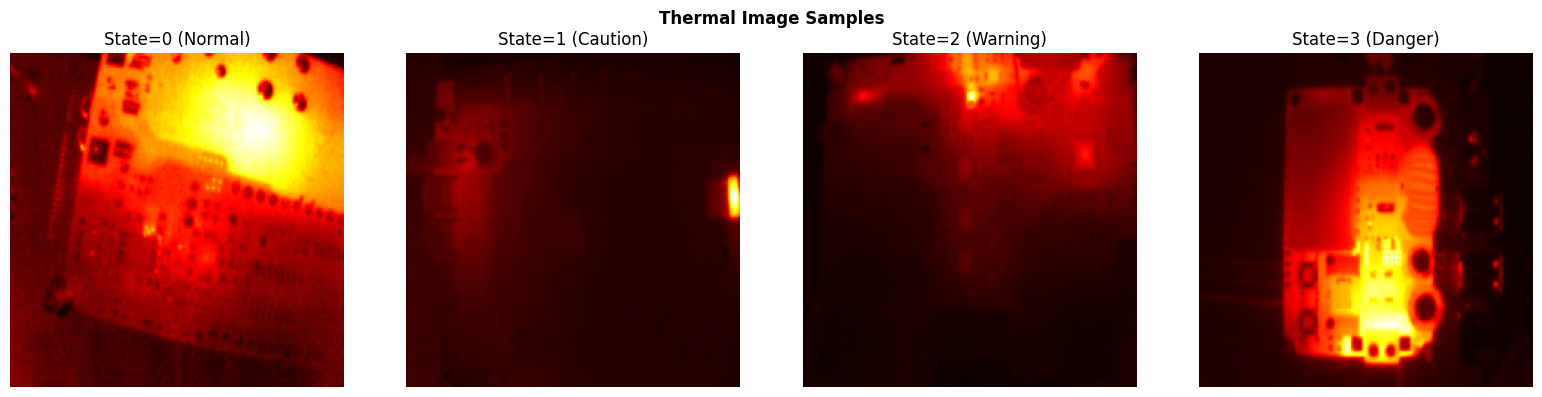

In [ ]:
# ======================================================================
#  BIN 파일 포맷
#
#  구조: [128-byte 헤더] + [120 x 160 float64 픽셀]
#    헤더:  128바이트 (메타데이터, 스킵)
#    픽셀:  120행 x 160열 x 8바이트(float64) = 153,600바이트
#    총합:  128 + 153,600 = 153,728바이트
#
#  각 픽셀 값은 섭씨 온도(℃)를 나타냄 (예: 43.7, 51.2)
#
#  [주의] NaN/Inf 방어
#    실제 BIN 파일 내부에 NaN(Not a Number)과 Inf(무한대)가
#    존재하는 사례가 확인됨 (센서 수집 오류 또는 결측).
#    이를 처리하지 않으면 모델 학습 시 loss가 NaN으로 폭발.
#    -> NaN/Inf를 이미지 중앙값(nanmedian)으로 대체
# ======================================================================

HEADER_SIZE = 128          # BIN 파일 헤더 크기 (바이트)
THERMAL_H, THERMAL_W = 120, 160   # 원본 이미지 해상도
IMG_SIZE = 224             # 모델 입력 크기 (224x224)

# 포맷 확인
sample_bin = windows[0]['bin_path']
file_size = os.path.getsize(sample_bin)
expected_size = HEADER_SIZE + THERMAL_H * THERMAL_W * 8  # float64 = 8 bytes
print(f"BIN 포맷 확인: {file_size:,} bytes, 예상={expected_size:,}, 일치={file_size == expected_size}")


def load_thermal_image(bin_path):
    """
    BIN 파일을 읽어 [1, 224, 224] 텐서로 변환.

    과정:
      1. 128바이트 헤더 스킵
      2. float64로 읽어 120x160 배열 생성
      3. NaN/Inf 값을 이미지 중앙값으로 대체 (안전 처리)
      4. Min-Max 정규화 -> [0, 1] 범위
      5. PIL로 224x224 리사이즈
      6. [1, 224, 224] 텐서 반환

    Args:
        bin_path: BIN 파일 경로

    Returns:
        tensor: [1, 224, 224] float32 텐서 (0~1 범위)
                실패 시 전체 0 텐서 반환
    """
    try:
        raw = np.fromfile(bin_path, dtype=np.uint8)
        data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
        img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)

        # NaN/Inf 방어: 유한하지 않은 값을 중앙값으로 대체
        if not np.all(np.isfinite(img)):
            median_val = np.nanmedian(img)
            if np.isnan(median_val):
                median_val = 0.0
            img = np.where(np.isfinite(img), img, median_val)

        # Min-Max 정규화
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img = (img - vmin) / (vmax - vmin)
        else:
            img = np.zeros_like(img)

        # 224x224 리사이즈
        pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
        tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
        return tensor.unsqueeze(0)    # [1, 224, 224]
    except:
        return torch.zeros(1, IMG_SIZE, IMG_SIZE)


# ======================================================================
#  NaN/Inf 오염 통계 확인
#  데이터 중 몇 %의 이미지에 NaN/Inf가 포함되어 있는지 확인
# ======================================================================

nan_count = 0
check_n = min(2000, len(windows))
for i in range(check_n):
    try:
        raw = np.fromfile(windows[i]['bin_path'], dtype=np.uint8)
        data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
        img = data.reshape(THERMAL_H, THERMAL_W)
        if not np.all(np.isfinite(img)):
            nan_count += 1
    except:
        pass
print(f"\nNaN/Inf 포함 이미지: {nan_count}/{check_n} ({nan_count/check_n*100:.1f}%)")

# 로딩 테스트
test_img = load_thermal_image(windows[0]['bin_path'])
print(f"로딩 테스트: shape={test_img.shape}, "
      f"범위=[{test_img.min():.3f}, {test_img.max():.3f}], "
      f"NaN={torch.isnan(test_img).any().item()}")

# 시각화: 4개 샘플 열화상 이미지
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, idx in enumerate([0, len(windows)//3, len(windows)*2//3, len(windows)-1]):
    img = load_thermal_image(windows[idx]['bin_path'])
    axes[i].imshow(img.squeeze(), cmap='hot')
    axes[i].set_title(f"State={windows[idx]['label_cls']} ({STATE_MAP[windows[idx]['label_cls']]})")
    axes[i].axis('off')
plt.suptitle('Thermal Image Samples', fontweight='bold')
plt.tight_layout()
plt.show()

# 5-1 번외 ML 성능과 성능개선한 MMT-S모델 비교를 위해 남겨둔 셀 (실행만) (베이스라인)

In [ ]:
# ======================================================================
#  이 셀에서 하는 일:
#    1. ML 모델용 피처 추출 (flatten + 통계량)
#    2. DL 모델용 PyTorch Dataset 정의
#    3. Train / Val / Test DataLoader 생성
# ======================================================================

CACHE_ML_TRAIN = os.path.join(CACHE_DIR, 'ml_train_v2.npz')
CACHE_ML_VAL   = os.path.join(CACHE_DIR, 'ml_val_v2.npz')
CACHE_ML_TEST  = os.path.join(CACHE_DIR, 'ml_test_v2.npz')

# ======================================================================
#  Part 1. ML 피처 추출
#
#  각 윈도우에서 추출하는 피처 (총 277차원):
#    센서 flatten:   30 timesteps x 8 channels = 240
#    센서 통계:      채널별 mean/std/min/max = 8 x 4 = 32
#    열화상 통계:    mean/std/min/max/median = 5
#    합계:           240 + 32 + 5 = 277
# ======================================================================

if (os.path.exists(CACHE_ML_TRAIN) and
    os.path.exists(CACHE_ML_VAL) and
    os.path.exists(CACHE_ML_TEST)):
    d_tr = np.load(CACHE_ML_TRAIN)
    d_va = np.load(CACHE_ML_VAL)
    d_te = np.load(CACHE_ML_TEST)
    X_train_ml, y_train_ml = d_tr['X'], d_tr['y']
    X_val_ml,   y_val_ml   = d_va['X'], d_va['y']
    X_test_ml,  y_test_ml  = d_te['X'], d_te['y']
    print(f"✅ ML 피처 캐시 로드:")
    print(f"   Train={X_train_ml.shape}, Val={X_val_ml.shape}, Test={X_test_ml.shape}")
else:
    def extract_ml_features(windows):
        """
        윈도우 리스트에서 ML용 피처 행렬과 라벨 배열을 추출.

        NaN/Inf 방어 로직 포함:
          열화상 이미지에 NaN/Inf가 있을 경우 중앙값으로 대체 후 통계 계산.

        Returns:
            features: [N, 277] float32 배열
            labels:   [N]     int 배열 (0~3)
        """
        features_list, labels_list = [], []
        for w in tqdm(windows, desc='ML 피처 추출'):
            # (a) 센서 flatten: [30, 8] -> [240]
            sensor_flat = w['sensor'].flatten()

            # (b) 센서 통계: 채널별 mean/std/min/max -> [32]
            sensor = w['sensor']
            s_mean = sensor.mean(axis=0)
            s_std  = sensor.std(axis=0)
            s_min  = sensor.min(axis=0)
            s_max  = sensor.max(axis=0)
            sensor_stats = np.concatenate([s_mean, s_std, s_min, s_max])

            # (c) 열화상 통계: [5]
            try:
                raw = np.fromfile(w['bin_path'], dtype=np.uint8)
                data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
                img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)
                # NaN/Inf 방어
                if not np.all(np.isfinite(img)):
                    med = np.nanmedian(img)
                    if np.isnan(med): med = 0.0
                    img = np.where(np.isfinite(img), img, med)
                img_stats = np.array([
                    img.mean(), img.std(), img.min(), img.max(), np.median(img)
                ])
            except:
                img_stats = np.zeros(5)

            feat = np.concatenate([sensor_flat, sensor_stats, img_stats])
            features_list.append(feat)
            labels_list.append(w['label_cls'])
        return np.array(features_list, dtype=np.float32), np.array(labels_list)

    print("Train 피처 추출 중...")
    X_train_ml, y_train_ml = extract_ml_features(train_windows)
    print("Val 피처 추출 중...")
    X_val_ml, y_val_ml = extract_ml_features(val_windows)
    print("Test 피처 추출 중...")
    X_test_ml, y_test_ml = extract_ml_features(test_windows)

    np.savez(CACHE_ML_TRAIN, X=X_train_ml, y=y_train_ml)
    np.savez(CACHE_ML_VAL,   X=X_val_ml,   y=y_val_ml)
    np.savez(CACHE_ML_TEST,  X=X_test_ml,  y=y_test_ml)
    print(f"✅ ML 피처 캐시 저장 완료")

# StandardScaler: Train 데이터로 fit, Val/Test에 transform
ml_scaler = StandardScaler()
X_train_ml_sc = ml_scaler.fit_transform(X_train_ml)
X_val_ml_sc   = ml_scaler.transform(X_val_ml)
X_test_ml_sc  = ml_scaler.transform(X_test_ml)

print(f"   피처: 센서 flatten({WINDOW_SIZE}x8={WINDOW_SIZE*8}) "
      f"+ 센서 통계(8x4=32) + 열화상 통계(5) = {X_train_ml.shape[1]}")

# ======================================================================
#  Part 2. DL Dataset 정의
#
#  각 샘플 반환값:
#    sensor:    [30, 8]        센서 시계열 (Z-score 정규화)
#    image:     [1, 224, 224]  열화상 이미지 (Min-Max 정규화)
#    label_reg: scalar (float) 회귀 라벨 (0.0 ~ 3.0)
#    label_cls: scalar (int)   분류 라벨 (0, 1, 2, 3)
# ======================================================================

class OHTMultimodalDataset(Dataset):
    """
    OHT 멀티모달 Dataset: 센서 시계열 + 열화상 이미지.

    특징:
      - 센서 정규화: Train의 mean/std로 Z-score 정규화 (Val/Test에도 동일 적용)
      - 이미지 로딩: load_thermal_image() 함수로 NaN/Inf 방어 + Min-Max 정규화
      - 센서 NaN 방어: torch.nan_to_num으로 최종 안전 처리

    Args:
        windows:      윈도우 리스트 (Cell 4에서 생성)
        sensor_mean:  센서 평균 (None이면 자동 계산)
        sensor_std:   센서 표준편차 (None이면 자동 계산)
        fit_scaler:   True이면 이 데이터에서 mean/std 계산 (Train용)
    """
    def __init__(self, windows, sensor_mean=None, sensor_std=None, fit_scaler=False):
        self.windows = windows
        all_sensors = np.stack([w['sensor'] for w in windows])
        if fit_scaler:
            # Train 데이터에서 센서 통계 계산
            self.sensor_mean = all_sensors.reshape(-1, 8).mean(axis=0)
            self.sensor_std  = all_sensors.reshape(-1, 8).std(axis=0) + 1e-8
        else:
            # Val/Test는 Train의 통계 사용
            self.sensor_mean = sensor_mean
            self.sensor_std  = sensor_std

    def __len__(self):
        return len(self.windows)

    def _load_image(self, bin_path):
        """BIN -> [1, 224, 224] 텐서 (NaN/Inf 방어 포함)"""
        try:
            raw = np.fromfile(bin_path, dtype=np.uint8)
            data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
            img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)
            if not np.all(np.isfinite(img)):
                med = np.nanmedian(img)
                if np.isnan(med): med = 0.0
                img = np.where(np.isfinite(img), img, med)
            vmin, vmax = img.min(), img.max()
            if vmax > vmin:
                img = (img - vmin) / (vmax - vmin)
            else:
                img = np.zeros_like(img)
            pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
            pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
            return tensor.unsqueeze(0)
        except:
            return torch.zeros(1, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        w = self.windows[idx]

        # 센서 Z-score 정규화 + NaN 안전 처리
        sensor = (w['sensor'] - self.sensor_mean) / self.sensor_std
        sensor = torch.from_numpy(sensor.astype(np.float32))
        sensor = torch.nan_to_num(sensor, nan=0.0, posinf=3.0, neginf=-3.0)

        # 이미지 로드 (NaN 방어 내장)
        image = self._load_image(w['bin_path'])

        # 라벨
        label_reg = torch.tensor(w['label'], dtype=torch.float32)
        label_cls = torch.tensor(w['label_cls'], dtype=torch.long)

        return sensor, image, label_reg, label_cls

# ======================================================================
#  Part 3. DataLoader 생성
# ======================================================================

# Train: scaler fit (이 데이터에서 센서 mean/std 계산)
train_dataset = OHTMultimodalDataset(train_windows, fit_scaler=True)

# Val/Test: Train의 통계 사용
val_dataset = OHTMultimodalDataset(
    val_windows,
    sensor_mean=train_dataset.sensor_mean,
    sensor_std=train_dataset.sensor_std,
)
test_dataset = OHTMultimodalDataset(
    test_windows,
    sensor_mean=train_dataset.sensor_mean,
    sensor_std=train_dataset.sensor_std,
)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)

# 배치 확인 + NaN 검증
sensor_batch, image_batch, label_reg, label_cls = next(iter(train_loader))
print(f"\n[DL 배치 확인] Sensor: {sensor_batch.shape}, Image: {image_batch.shape}")
print(f"  Sensor NaN: {torch.isnan(sensor_batch).any().item()}")
print(f"  Image  NaN: {torch.isnan(image_batch).any().item()}")
print(f"  Label  NaN: {torch.isnan(label_reg).any().item()}")

print(f"\n✅ 전체 데이터 준비 완료 (NaN/Inf 방어 적용)")
print(f"   Train: {len(train_dataset):>6,} -> {len(train_loader):>4} batches (장비 01~14)")
print(f"   Val:   {len(val_dataset):>6,} -> {len(val_loader):>4} batches (장비 15~16)")
print(f"   Test:  {len(test_dataset):>6,} -> {len(test_loader):>4} batches (장비 17~18)")

Train 피처 추출 중...


ML 피처 추출:   0%|          | 0/79397 [00:00<?, ?it/s]

Val 피처 추출 중...


ML 피처 추출:   0%|          | 0/11292 [00:00<?, ?it/s]

Test 피처 추출 중...


ML 피처 추출:   0%|          | 0/11263 [00:00<?, ?it/s]

✅ ML 피처 캐시 저장 완료
   피처: 센서 flatten(30x8=240) + 센서 통계(8x4=32) + 열화상 통계(5) = 277

[DL 배치 확인] Sensor: torch.Size([32, 30, 8]), Image: torch.Size([32, 1, 224, 224])
  Sensor NaN: False
  Image  NaN: False
  Label  NaN: False

✅ 전체 데이터 준비 완료 (NaN/Inf 방어 적용)
   Train: 79,397 -> 2481 batches (장비 01~14)
   Val:   11,292 ->  353 batches (장비 15~16)
   Test:  11,263 ->  352 batches (장비 17~18)


# 6. DL Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

# ======================================================================
# 🚀 [B실험] EMNLP 2022 기반 TMI Dataset (성능개선1 기반)
# ======================================================================

class EMNLP2022ExpBDataset(Dataset):
    """
    EMNLP 2022 'Task-specific Mutual Information' 논문 원리 적용 데이터셋.
    성능개선 1의 통합 EDA 데이터 구조를 계승하며, 모델의 정보 보존 능력을 강제로 시험함.

    [논문 핵심 기법]
    1. Dual-View 생성: 원본(Clean)과 손상본(Corrupted) 이미지를 동시에 모델에 제공.
    2. Data Corruption: Gaussian Noise 혹은 Patch Masking을 통해 시각 정보를 의도적으로 파괴.
    3. Robustness Test: '망가진 이미지'에서도 '원본'과 동일한 특징을 추출하는지 Trainer에서 시험하기 위한 구조.
    """
    def __init__(self, windows, corruption_type='patch', mask_ratio=0.3, sensor_mean=None, sensor_std=None, fit_scaler=False):
        self.windows = windows
        # [변인 설정] patch: 16x16 패치 가리기, gaussian: 무작위 노이즈 추가
        self.corruption_type = corruption_type
        self.mask_ratio = mask_ratio # 마스킹 비율 혹은 노이즈 강도

        # 성능개선 1: 센서 Z-score 정규화 파라미터 관리
        if fit_scaler:
            all_sensors = np.stack([w['sensor'] for w in windows])
            self.sensor_mean = all_sensors.reshape(-1, 8).mean(axis=0)
            self.sensor_std  = all_sensors.reshape(-1, 8).std(axis=0) + 1e-8
        else:
            self.sensor_mean = sensor_mean
            self.sensor_std  = sensor_std

    def __len__(self):
        return len(self.windows)

    def _apply_corruption(self, image_tensor):
        """
        [EMNLP 2022 원리] 이미지의 핵심 특징 파악 능력을 강제로 시험하기 위한 손상 로직
        - Patch Masking: 맥락(Context)을 이해하지 못하면 정답을 맞출 수 없게 함.
        - Gaussian Noise: 입력의 미세한 변화(Robustness)에 얼마나 강한지 시험함.
        """
        corrupted = image_tensor.clone()

        if self.corruption_type == 'patch':
            # 패치 단위 마스킹 (16x16)
            p = 16
            c, h, w = image_tensor.shape
            num_h, num_w = h // p, w // p
            num_total = num_h * num_w
            num_mask = int(num_total * self.mask_ratio)

            mask_idx = torch.randperm(num_total)[:num_mask]
            for idx in mask_idx:
                i = (idx // num_w) * p
                j = (idx % num_w) * p
                corrupted[:, i:i+p, j:j+p] = 0.0 # 정보 차단

        elif self.corruption_type == 'gaussian':
            # 가우시안 노이즈 추가
            noise = torch.randn_like(corrupted) * self.mask_ratio
            corrupted = torch.clamp(corrupted + noise, 0, 1)

        return corrupted

    def _load_thermal(self, bin_path):
        """성능개선 1: NaN 방어 및 리사이즈 로직 유지"""
        try:
            raw = np.fromfile(bin_path, dtype=np.uint8)
            data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
            img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)

            if not np.all(np.isfinite(img)):
                med = np.nanmedian(img); img = np.where(np.isfinite(img), img, med if not np.isnan(med) else 0.0)

            vmin, vmax = img.min(), img.max()
            img = (img - vmin) / (vmax - vmin) if vmax > vmin else np.zeros_like(img)

            pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
            pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            return torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0).unsqueeze(0)
        except:
            return torch.zeros(1, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        w = self.windows[idx]

        # 1. 센서 데이터 (Z-score)
        sensor = (w['sensor'] - self.sensor_mean) / self.sensor_std
        sensor = torch.nan_to_num(torch.from_numpy(sensor.astype(np.float32)), 0.0)

        # 2. 이미지 데이터 (Dual-View 생성)
        # [원본] img_resized: 스승이자 가이드 역할 (Information Source)
        img_resized = self._load_thermal(w['bin_path'])

        # [손상본] img_corrupted: 모델이 뚫고 지나가야 할 시련 (Test Case)
        # Train 시에만 Corruption 적용, Val/Test 시에는 원본 그대로 사용(비율 0.0)
        img_corrupted = self._apply_corruption(img_resized) if self.mask_ratio > 0 else img_resized

        # 3. 라벨 및 장비 정보 (성능개선 1 유지)
        label_reg = torch.tensor(w['label'], dtype=torch.float32)
        label_cls = torch.tensor(w['label_cls'], dtype=torch.long)
        device_type = torch.tensor(0 if w['device_type'] == 'oht' else 1, dtype=torch.long)

        return {
            'sensor': sensor,
            'image_corrupted': img_corrupted,       # 모델이 학습(도전)할 손상 이미지
            'image_resized': img_resized,  # TMI Loss 계산을 위한 기준 이미지
            'label_reg': label_reg,
            'label_cls': label_cls,
            'device_type': device_type
        }

# ======================================================================
# 🚀 B실험 세팅 및 DataLoader (Corruption 변인 통제)
# ======================================================================

# [변인 통제] 마스킹 비율 0.3으로 시작 (너무 높으면 정보 소실로 학습 불가)
train_dataset = EMNLP2022ExpBDataset(train_windows, corruption_type='patch', mask_ratio=0.3, fit_scaler=True)
val_dataset   = EMNLP2022ExpBDataset(val_windows, mask_ratio=0.0, sensor_mean=train_dataset.sensor_mean, sensor_std=train_dataset.sensor_std)
test_dataset  = EMNLP2022ExpBDataset(test_windows, mask_ratio=0.0, sensor_mean=train_dataset.sensor_mean, sensor_std=train_dataset.sensor_std)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# 샘플 및 보고서 출력
sample = next(iter(train_loader))
print(f"✅ B실험 Ready: Corrupted {sample['image_corrupted'].shape}, Resized {sample['image_resized'].shape}")
print(f"📊 [EMNLP 2022] Corruption Type: {train_dataset.corruption_type}, Ratio: {train_dataset.mask_ratio}")

✅ B실험 Ready: Corrupted torch.Size([32, 1, 224, 224]), Resized torch.Size([32, 1, 224, 224])
📊 [EMNLP 2022] Corruption Type: patch, Ratio: 0.3


# 7. ML 모델 학습 & 평가 (베이스라인)

In [ ]:
# ======================================================================
#  4가지 ML 모델 학습 및 평가
#
#  모델 구성:
#    RandomForest:  앙상블 결정 트리 (CPU)
#    XGBoost:       Gradient Boosting (GPU 가속, device='cuda')
#    LightGBM:      경량 Gradient Boosting (GPU 가속)
#    CatBoost:      범주형 지원 Gradient Boosting (GPU 가속)
#
#  입력: 277차원 피처 벡터 (센서 flatten + 통계 + 열화상 통계)
#  출력: 4클래스 분류 (0=정상, 1=관심, 2=경고, 3=위험)
#
#  평가: Train(장비 01~14) + Val(장비 15~16) + Test(장비 17~18) 모두 출력
#
#  [참고] 트리 기반 모델은 스케일링 불필요
#    RF/XGB/LGBM/CatBoost는 분할 기준이 순서(rank)이므로
#    StandardScaler 적용 여부가 결과에 영향 없음.
#    따라서 fit과 predict 모두 원본(unscaled) 데이터 사용.
#    (X_train_ml_sc는 DL 피처용으로 별도 존재)
#
#  [XGBoost 3.1+ 변경사항]
#    tree_method='gpu_hist'와 gpu_id 파라미터가 제거됨.
#    대신 device='cuda' (GPU) 또는 device='cpu' (CPU)를 사용.
# ======================================================================

def evaluate_predictions(y_true, y_pred_cls, y_pred_reg=None):
    """
    분류 예측 결과로 RMSE, Macro F1, Macro Recall 계산.

    Args:
        y_true:      실제 라벨 (int, 0~3)
        y_pred_cls:  예측 클래스 (int, 0~3)
        y_pred_reg:  회귀 예측값 (float, 없으면 cls 사용)

    Returns:
        rmse, f1, recall
    """
    if y_pred_reg is None:
        y_pred_reg = y_pred_cls.astype(float)
    rmse   = np.sqrt(mean_squared_error(y_true.astype(float), y_pred_reg))
    f1     = f1_score(y_true, y_pred_cls, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred_cls, average='macro', zero_division=0)
    return rmse, f1, recall


# 모델 정의 (GPU 가속 옵션 포함)
ml_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=300, max_depth=20, min_samples_split=5,
        class_weight='balanced', random_state=42, n_jobs=-1),

    'XGBoost': XGBClassifier(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        device='cuda',
        random_state=42, eval_metric='mlogloss', use_label_encoder=False),

    'LightGBM': LGBMClassifier(
        n_estimators=300, max_depth=10, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        class_weight='balanced', random_state=42,
        device='gpu', gpu_use_dp=False, verbose=-1),

    'CatBoost': CatBoostClassifier(
        iterations=300, depth=8, learning_rate=0.1,
        task_type='GPU', devices='0',
        auto_class_weights='Balanced', random_seed=42, verbose=0),
}

# 전체 실험 결과를 누적할 리스트
all_results = []

CACHE_ML_RESULTS = os.path.join(CACHE_DIR, 'ml_results_v3.pkl')

# ======================================================================
#  캐시 존재 시 로드
# ======================================================================

if os.path.exists(CACHE_ML_RESULTS):
    with open(CACHE_ML_RESULTS, 'rb') as f:
        cache = pickle.load(f)
        all_results = cache['all_results']
        ml_models   = cache['ml_models']
    print(f"✅ ML 결과 캐시 로드: {len(all_results)}개 모델")
    for r in all_results:
        print(f"  {r['Model']:15s}: Train F1={r['Train F1']:.4f}, "
              f"Val F1={r['Val F1']:.4f}, Test F1={r['Test F1']:.4f}")

else:
    print(f"{'='*65}")
    print(f"  ML Models Training ({len(ml_models)} models)")
    print(f"{'='*65}")

    for name, model in ml_models.items():
        print(f"\n  > Training: {name}...", end=' ')
        t0 = time.time()
        try:
            model.fit(X_train_ml, y_train_ml)
            elapsed = time.time() - t0

            # Train / Val / Test 모두 평가 (unscaled 원본 사용)
            y_train_pred = model.predict(X_train_ml)
            y_val_pred   = model.predict(X_val_ml)
            y_test_pred  = model.predict(X_test_ml)

            train_rmse, train_f1, train_recall = evaluate_predictions(y_train_ml, y_train_pred)
            val_rmse,   val_f1,   val_recall   = evaluate_predictions(y_val_ml, y_val_pred)
            test_rmse,  test_f1,  test_recall  = evaluate_predictions(y_test_ml, y_test_pred)

            all_results.append({
                'Category': 'ML', 'Model': name,
                'Train RMSE': train_rmse, 'Train F1': train_f1, 'Train Recall': train_recall,
                'Val RMSE': val_rmse, 'Val F1': val_f1, 'Val Recall': val_recall,
                'Test RMSE': test_rmse, 'Test F1': test_f1, 'Test Recall': test_recall,
                'Time(s)': elapsed,
            })
            print(f"완료 ({elapsed:.1f}s)")
            print(f"    Train: RMSE={train_rmse:.4f}, F1={train_f1:.4f}, Recall={train_recall:.4f}")
            print(f"    Val:   RMSE={val_rmse:.4f}, F1={val_f1:.4f}, Recall={val_recall:.4f}")
            print(f"    Test:  RMSE={test_rmse:.4f}, F1={test_f1:.4f}, Recall={test_recall:.4f}")

        except Exception as e:
            print(f"GPU 실패 -> CPU 재시도: {e}")
            if name == 'XGBoost':
                model = XGBClassifier(
                    n_estimators=300, max_depth=8, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8,
                    device='cpu',
                    random_state=42, eval_metric='mlogloss', use_label_encoder=False)
            elif name == 'LightGBM':
                model = LGBMClassifier(
                    n_estimators=300, max_depth=10, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.8, class_weight='balanced',
                    random_state=42, device='cpu', verbose=-1)
            elif name == 'CatBoost':
                model = CatBoostClassifier(
                    iterations=300, depth=8, learning_rate=0.1,
                    task_type='CPU', auto_class_weights='Balanced',
                    random_seed=42, verbose=0)

            ml_models[name] = model
            t0 = time.time()
            model.fit(X_train_ml, y_train_ml)
            elapsed = time.time() - t0

            # CPU fallback도 unscaled 원본 사용
            y_train_pred = model.predict(X_train_ml)
            y_val_pred   = model.predict(X_val_ml)
            y_test_pred  = model.predict(X_test_ml)

            train_rmse, train_f1, train_recall = evaluate_predictions(y_train_ml, y_train_pred)
            val_rmse,   val_f1,   val_recall   = evaluate_predictions(y_val_ml, y_val_pred)
            test_rmse,  test_f1,  test_recall  = evaluate_predictions(y_test_ml, y_test_pred)

            all_results.append({
                'Category': 'ML', 'Model': name,
                'Train RMSE': train_rmse, 'Train F1': train_f1, 'Train Recall': train_recall,
                'Val RMSE': val_rmse, 'Val F1': val_f1, 'Val Recall': val_recall,
                'Test RMSE': test_rmse, 'Test F1': test_f1, 'Test Recall': test_recall,
                'Time(s)': elapsed,
            })
            print(f"    완료 ({elapsed:.1f}s)")
            print(f"    Train: RMSE={train_rmse:.4f}, F1={train_f1:.4f}, Recall={train_recall:.4f}")
            print(f"    Val:   RMSE={val_rmse:.4f}, F1={val_f1:.4f}, Recall={val_recall:.4f}")
            print(f"    Test:  RMSE={test_rmse:.4f}, F1={test_f1:.4f}, Recall={test_recall:.4f}")

    with open(CACHE_ML_RESULTS, 'wb') as f:
        pickle.dump({'all_results': all_results, 'ml_models': ml_models}, f)
    print(f"\n✅ ML 결과 캐시 저장 완료")

# ======================================================================
#  결과 요약 테이블
# ======================================================================

print(f"\n{'='*95}")
print(f"  ML 모델 Train / Val / Test 성능 비교")
print(f"{'='*95}")
print(f"  {'모델':15s} | {'Train RMSE':>10s} {'Train F1':>9s} | "
      f"{'Val RMSE':>9s} {'Val F1':>7s} | {'Test RMSE':>10s} {'Test F1':>8s}")
print(f"  {'─'*90}")
for r in all_results:
    if r['Category'] != 'ML':
        continue
    print(f"  {r['Model']:15s} | "
          f"{r['Train RMSE']:>10.4f} {r['Train F1']:>9.4f} | "
          f"{r['Val RMSE']:>9.4f} {r['Val F1']:>7.4f} | "
          f"{r['Test RMSE']:>10.4f} {r['Test F1']:>8.4f}")
print(f"{'='*95}")

  ML Models Training (4 models)

  > Training: RandomForest... 완료 (26.4s)
    Train: RMSE=0.0094, F1=0.9999, Recall=0.9999
    Val:   RMSE=0.2087, F1=0.9536, Recall=0.9543
    Test:  RMSE=0.3148, F1=0.9467, Recall=0.9522

  > Training: XGBoost... 완료 (4.7s)
    Train: RMSE=0.0000, F1=1.0000, Recall=1.0000
    Val:   RMSE=0.1783, F1=0.9666, Recall=0.9675
    Test:  RMSE=0.3037, F1=0.9534, Recall=0.9567

  > Training: LightGBM... 완료 (15.0s)
    Train: RMSE=0.0000, F1=1.0000, Recall=1.0000
    Val:   RMSE=0.1861, F1=0.9640, Recall=0.9650
    Test:  RMSE=0.3115, F1=0.9497, Recall=0.9548

  > Training: CatBoost... 완료 (3.7s)
    Train: RMSE=0.0842, F1=0.9908, Recall=0.9929
    Val:   RMSE=0.1793, F1=0.9637, Recall=0.9649
    Test:  RMSE=0.2980, F1=0.9557, Recall=0.9608

✅ ML 결과 캐시 저장 완료

  ML 모델 Train / Val / Test 성능 비교
  모델              | Train RMSE  Train F1 |  Val RMSE  Val F1 |  Test RMSE  Test F1
  ──────────────────────────────────────────────────────────────────────────────────────────

# 8. DL 모델 정의

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as tv_models

# ==============================================================================
#  1. CNN (RegNetY-3.2GF) — 단일모달 (기존 유지)
# ==============================================================================
class CNNRegNet(nn.Module):
    # (기존 성능개선1 코드와 동일하므로 생략 없이 원본 유지)
    def __init__(self, in_channels=1):
        super().__init__()
        self.in_channels = in_channels
        regnet = tv_models.regnet_y_3_2gf(weights=None)
        orig_conv = regnet.stem[0]
        regnet.stem[0] = nn.Conv2d(in_channels, orig_conv.out_channels, kernel_size=orig_conv.kernel_size, stride=orig_conv.stride, padding=orig_conv.padding, bias=(orig_conv.bias is not None))
        self.backbone = nn.Sequential(regnet.stem, regnet.trunk_output)
        self.pool = nn.AdaptiveAvgPool2d(1)
        with torch.no_grad():
            feat_dim = self.backbone(torch.zeros(1, in_channels, 224, 224)).shape[1]
        self.head = nn.Sequential(nn.Linear(feat_dim, 256), nn.GELU(), nn.Dropout(0.1), nn.Linear(256, 1))

    def forward(self, sensor, image):
        x = image.repeat(1, 3, 1, 1) if self.in_channels == 3 else image
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        return self.head(x).squeeze(-1)

# ==============================================================================
#  2. LSTM — 단일모달 (기존 유지)
# ==============================================================================
class SensorLSTM(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.head = nn.Sequential(nn.Linear(hidden_dim * 2, 128), nn.GELU(), nn.Dropout(dropout), nn.Linear(128, 1))

    def forward(self, sensor, image):
        out, _ = self.lstm(sensor)
        return self.head(out[:, -1, :]).squeeze(-1)

# ==============================================================================
#  3. CNN + LSTM — 멀티모달 Late Fusion (기존 유지)
# ==============================================================================
class CNN_LSTM(nn.Module):
    def __init__(self, sensor_dim=8, hidden_dim=128, num_layers=2):
        super().__init__()
        regnet = tv_models.regnet_y_3_2gf(weights=None)
        orig_conv = regnet.stem[0]
        regnet.stem[0] = nn.Conv2d(1, orig_conv.out_channels, kernel_size=orig_conv.kernel_size, stride=orig_conv.stride, padding=orig_conv.padding, bias=(orig_conv.bias is not None))
        self.cnn_backbone = nn.Sequential(regnet.stem, regnet.trunk_output)
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)
        with torch.no_grad(): cnn_out_dim = self.cnn_backbone(torch.zeros(1, 1, 224, 224)).shape[1]
        self.lstm = nn.LSTM(input_size=sensor_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.2 if num_layers > 1 else 0, bidirectional=True)
        self.head = nn.Sequential(nn.Linear(cnn_out_dim + hidden_dim * 2, 256), nn.GELU(), nn.Dropout(0.2), nn.Linear(256, 64), nn.GELU(), nn.Dropout(0.1), nn.Linear(64, 1))

    def forward(self, sensor, image):
        img_feat = self.cnn_pool(self.cnn_backbone(image)).flatten(1)
        lstm_out, _ = self.lstm(sensor)
        return self.head(torch.cat([img_feat, lstm_out[:, -1, :]], dim=1)).squeeze(-1)

# ==============================================================================
#  4. MMT — MultiModal Transformer [실험 B: EMNLP 2022 TMI 기반 구조 설명]
# ==============================================================================
#
#  [실험 B (EMNLP 2022) 논문 기능 구현을 위한 뼈대 역할]
#
#   1. 왜 구조를 바꾸지 않고 그대로 쓰는가?
#      - 논문의 핵심은 "모델 아키텍처 변경"이 아니라 "정보 추출 능력의 강제 시험"입니다.
#      - 6번 셀에서 만든 '손상된 이미지(img_corrupted)'가 이 모델에 입력으로 들어옵니다.
#
#   2. Patch Masking (16x16) 방어 메커니즘
#      - 이미지가 16x16 패치로 쪼개질 때(총 196개), 6번 셀에 의해 약 30%의 패치가 까맣게(0.0) 타버립니다.
#      - 하지만 MMT의 **Transformer Encoder (Self-Attention)** 구조 덕분에,
#        모델은 타버린 빈자리를 '살아남은 주변 이미지 패치'와 '30타임스텝의 센서 데이터'를 참조하여
#        문맥(Context)을 추론하고 빈 공간의 정보를 스스로 채워 넣습니다.
#
#   3. TMI Loss (상호의존도) 계산의 핵심: [CLS] Token
#      - 9번 셀(Trainer)에서는 이 모델을 한 배치당 2번 호출합니다.
#        A. 예측_원본 = model(sensor, img_resized)
#        B. 예측_손상 = model(sensor, img_corrupted)
#      - 이 두 번의 Forward 과정에서 나온 최종 출력(`pred_cls`)을 바탕으로 KL-Divergence를 계산합니다.
#      - 모델이 똑똑하다면, 이미지가 망가졌어도 센서와의 결합(Cross-modal Attention)을 통해
#        [CLS] 토큰에 '원본과 동일한 핵심 정보'를 응집시킬 것입니다. 이것이 TMI Loss의 타겟입니다.
# ==============================================================================

class MultimodalTransformer(nn.Module):
    """
    MMT-S (성능개선 1 뼈대 + 실험 B 강건성 시험 대응)
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=1,
                 sensor_seq_len=30, sensor_dim=8,
                 d_model=128, nhead=4, num_layers=4, d_ff=512, dropout=0.1):
        super().__init__()
        self.d_model    = d_model
        self.patch_size = patch_size

        num_patches = (img_size // patch_size) ** 2     # 196
        patch_dim = in_channels * patch_size ** 2       # 256
        self.num_patches = num_patches

        # Image Patch & Positional Embedding
        self.patch_embed = nn.Linear(patch_dim, d_model)
        self.img_pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)

        # Sensor & Positional Embedding
        self.sensor_embed = nn.Linear(sensor_dim, d_model)
        self.sensor_pos_embed = nn.Parameter(torch.randn(1, sensor_seq_len, d_model) * 0.02)

        # [CLS] Token & Device Embedding (OHT/AGV)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        self.device_embed = nn.Embedding(2, d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_ff,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

        # Multi-task Heads
        # TMI Loss는 이 헤드들을 통과한 결과값(분포)을 기반으로 "정보가 얼마나 살아남았는지"를 측정합니다.
        self.head_reg = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 1))
        self.head_cls = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))

    def _patchify(self, images):
        B, C, H, W = images.shape
        p = self.patch_size
        x = images.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, C, -1, p, p)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        return x.view(B, self.num_patches, -1)

    def forward(self, sensor, image, device_idx):
        B = sensor.shape[0]

        # 1. 패치화 및 임베딩 (실험B에서는 image 자리에 주로 img_corrupted가 들어와 시련을 줍니다)
        patches = self._patchify(image)
        img_tokens = self.patch_embed(patches) + self.img_pos_embed
        sen_tokens = self.sensor_embed(sensor) + self.sensor_pos_embed

        # 2. [CLS] 토큰과 장비 정보 결합
        cls = self.cls_token.expand(B, -1, -1)
        dev_embed = self.device_embed(device_idx).unsqueeze(1)
        cls = cls + dev_embed

        # 3. 전역 결합 및 Self-Attention (시각 정보 파괴 시 방어 메커니즘 작동 지점)
        tokens = torch.cat([cls, img_tokens, sen_tokens], dim=1)
        out = self.transformer(tokens)

        # 4. 최종 [CLS] 출력 기반 예측
        cls_out = self.norm(out[:, 0, :])
        pred_reg = self.head_reg(cls_out).squeeze(-1)
        pred_cls = self.head_cls(cls_out)

        return pred_reg, pred_cls


# ==============================================================================
#  모델 등록 — B실험 (EMNLP 2022) 대응
# ==============================================================================
dl_model_configs = {
    # 기존 모델 설정은 주석 처리 또는 유지 (필요 시 주석 해제하여 사용)
    # 'CNN+LSTM': { ... }

    # [실험 B 메인 타겟] EMNLP 2022 TMI 로직을 시험할 대상 모델
    'MMT-S_ExpB': {
        'class':       MultimodalTransformer,
        'kwargs':      {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'd_ff': 512},
        'category':    '멀티모달_실험B',
        'description': 'EMNLP 2022 TMI 강건성 시험용 (Small)',
    },
}

# -- 모델 요약 출력 --
print(f"{'='*75}")
print(f"  DL Models Summary (실험 B - EMNLP 2022 TMI 모델)")
print(f"{'='*75}")
print(f"  {'모델':12s} {'카테고리':12s} {'파라미터':>10s}   설명")
print(f"  {'─'*70}")
for name, cfg in dl_model_configs.items():
    m = cfg['class'](**cfg['kwargs'])
    n_params = sum(p.numel() for p in m.parameters())
    print(f"  {name:12s} {cfg['category']:12s} {n_params:>10,}   {cfg['description']}")
    del m
print(f"{'='*75}")

  DL Models Summary (실험 B - EMNLP 2022 TMI 모델)
  모델           카테고리               파라미터   설명
  ──────────────────────────────────────────────────────────────────────
  MMT-S_ExpB   멀티모달_실험B        873,541   EMNLP 2022 TMI 강건성 시험용 (Small)


# 9. DL 학습/평가 함수

In [ ]:
# ======================================================================
#  [B실험] EMNLP 2022 기반 학습/평가 함수 (TMI Loss 장착)
# ======================================================================
import time
import math
import wandb
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, recall_score

WANDB_PROJECT = 'MMT-OHT-Degradation'
WANDB_ENTITY  = None

def init_wandb_run(model_name, model, config_extra=None):
    if not WANDB_ENABLED: return None
    n_params = sum(p.numel() for p in model.parameters())
    cfg = dl_model_configs.get(model_name, {})
    config = {
        'model_name':   model_name,
        'category':     cfg.get('category', 'Unknown'),
        'n_params':     n_params,
        'num_epochs':   30,
        'batch_size':   BATCH_SIZE,
        'lr':           1e-5,
        'weight_decay': 1e-2,
        'window_size':  WINDOW_SIZE,
        'window_step':  WINDOW_STEP,
        'optimizer':    'AdamW',
        'experiment':   'ExpB_EMNLP2022_TMI', # B실험 태그 추가
    }
    if 'kwargs' in cfg: config.update({f'model/{k}': v for k, v in cfg['kwargs'].items()})
    if config_extra: config.update(config_extra)
    try: wandb.finish()
    except: pass
    return wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, name=model_name, config=config)

# ======================================================================
#  🚀 핵심 훈련 로직 (Train One Epoch)
# ======================================================================
def train_one_epoch(model, loader, criterion_reg, optimizer, scheduler, device,
                    epoch=None, num_epochs=None, model_name='',
                    wandb_run=None, global_step=0):
    model.train()
    total_loss, n_samples = 0, 0

    criterion_cls = nn.CrossEntropyLoss()

    # ==============================================================================
    # [EMNLP 2022 논문 핵심 1: TMI Loss 선언]
    # Mutual Information(상호의존도)을 계산하기 위해 KL-Divergence Loss를 사용합니다.
    # 목적: "망가진 이미지(Corrupted)를 보고 판단한 확률 분포가,
    #        깨끗한 이미지(Resized)를 보고 판단한 확률 분포와 최대한 같아지도록(최소화)" 강제합니다.
    # ==============================================================================
    criterion_tmi = nn.KLDivLoss(reduction='batchmean')

    desc = f"  [{model_name}] Epoch {epoch}/{num_epochs}" if epoch else "  Training"
    pbar = tqdm(loader, desc=desc, leave=False, bar_format='{l_bar}{bar:30}{r_bar}')

    for batch in pbar:
        sensor      = batch['sensor'].to(device)
        label_reg   = batch['label_reg'].to(device)
        label_cls   = batch['label_cls'].to(device).long()
        device_idx  = batch['device_type'].to(device)

        # [실험 B의 핵심] 6번 셀에서 가져온 두 가지 버전의 이미지
        img_orig = batch['image_resized'].to(device)   # 깨끗한 원본 (가이드)
        img_corr = batch['image_corrupted'].to(device) # 구멍 뚫린 손상본 (시련)

        optimizer.zero_grad()

        if isinstance(model, MultimodalTransformer):
            # ==========================================================================
            # [EMNLP 2022 논문 핵심 2: 강제 시험 메커니즘 실행]
            # ==========================================================================

            # STEP 1. [가이드 생성] 깨끗한 원본 이미지로 예측 (기울기 계산 안 함)
            # 모델 스스로가 생각하는 "이 데이터의 진짜 핵심 정답지(Soft Label)"를 만듭니다.
            with torch.no_grad():
                _, pred_cls_orig = model(sensor, img_orig, device_idx)

            # STEP 2. [시련 통과] 망가진 이미지로 예측 (실제 학습 대상)
            # 구멍 뚫린 이미지를 보고도 센서 데이터와 남은 픽셀들을 쥐어짜서 예측을 해냅니다.
            pred_reg_corr, pred_cls_corr = model(sensor, img_corr, device_idx)

            # STEP 3. [기본 Loss 계산] 정답을 맞히는 능력 (Task Loss)
            loss_reg = criterion_reg(pred_reg_corr, label_reg)
            loss_cls = criterion_cls(pred_cls_corr, label_cls)
            loss_task = loss_reg + 0.5 * loss_cls

            # STEP 4. [논문 핵심: TMI Loss 계산]
            # p_orig(가이드)와 p_corr(학생)의 확률 분포 차이를 계산합니다.
            # * 주의: KLDivLoss는 입력으로 log_softmax, 타겟으로 일반 softmax를 받습니다.
            p_orig = torch.softmax(pred_cls_orig, dim=1)           # [Target] 깨끗한 분포
            p_corr = torch.log_softmax(pred_cls_corr, dim=1)       # [Input] 망가진 분포
            loss_tmi = criterion_tmi(p_corr, p_orig)               # 두 분포 간의 거리(차이)

            # STEP 5. [최종 Loss] = 기본 임무 달성도 + 특징 추출 강건성
            # 논문 기반 가중치(0.1)를 곱하여 TMI Loss가 Task Loss를 너무 압도하지 않게 조율합니다.
            loss = loss_task + 0.1 * loss_tmi

        else:
            # Baseline 모델(CNN 등)은 TMI 없이 기본 Task 학습만 수행
            pred = model(sensor, img_corr)
            loss = criterion_reg(pred, label_reg)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler: scheduler.step()

        batch_size  = sensor.size(0)
        total_loss += loss.item() * batch_size
        n_samples  += batch_size
        global_step += 1

        if wandb_run and global_step % 50 == 0:
            log_dict = {'train/total_loss': loss.item(), 'train/lr': optimizer.param_groups[0]['lr']}
            if isinstance(model, MultimodalTransformer):
                log_dict.update({'train/loss_reg': loss_reg.item(), 'train/loss_cls': loss_cls.item(), 'train/loss_tmi': loss_tmi.item()})
            wandb_run.log(log_dict, step=global_step)

        pbar.set_postfix({'loss': f'{total_loss / n_samples:.4f}'})
    pbar.close()
    return total_loss / n_samples, global_step

# ======================================================================
#  평가 및 파이프라인 함수 (기존 로직 유지, 평가 시에는 깨끗한 이미지 사용)
# ======================================================================
def evaluate_dl(model, loader, device):
    model.eval()
    all_preds, all_labels_reg, all_labels_cls = [], [], []
    with torch.no_grad():
        for batch in loader:
            sensor = batch['sensor'].to(device)
            # 평가(Test/Val) 시에는 공정한 실력 측정을 위해 '깨끗한 원본'을 사용합니다.
            image = batch['image_resized'].to(device)
            device_idx = batch['device_type'].to(device)

            if isinstance(model, MultimodalTransformer):
                pred_reg, _ = model(sensor, image, device_idx)
                all_preds.append(pred_reg.cpu().numpy())
            else:
                pred = model(sensor, image)
                all_preds.append(pred.cpu().numpy())

            all_labels_reg.append(batch['label_reg'].numpy())
            all_labels_cls.append(batch['label_cls'].numpy())

    preds      = np.concatenate(all_preds)
    labels_reg = np.concatenate(all_labels_reg)
    labels_cls = np.concatenate(all_labels_cls)

    rmse = np.sqrt(np.mean((preds - labels_reg) ** 2))
    pred_cls = np.clip(np.round(preds), 0, 3).astype(int)
    f1       = f1_score(labels_cls, pred_cls, average='macro', zero_division=0)
    recall   = recall_score(labels_cls, pred_cls, average='macro', zero_division=0)

    return rmse, f1, recall, preds, labels_cls

def train_dl_model(name, model, train_loader, val_loader, test_loader, device, num_epochs=30, lr=1e-3):
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\n{'='*65}")
    print(f"  Training (B실험 - TMI Loss): {name}")
    print(f"  Params: {n_params:,}  |  Epochs: {num_epochs}  |  LR: {lr}")
    print(f"{'='*65}")

    wandb_run = init_wandb_run(name, model)
    model = model.to(device)
    criterion_reg = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

    total_steps  = num_epochs * len(train_loader)
    warmup_steps = min(500, total_steps // 5)
    def lr_lambda(step):
        if step < warmup_steps: return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_val_f1, best_state = 0, None
    best_val_rmse, best_val_recall, best_epoch = 0, 0, 0
    history = {'train_loss': [], 'val_rmse': [], 'val_f1': [], 'val_recall': [], 'test_rmse': [], 'test_f1': [], 'test_recall': []}
    global_step, t0 = 0, time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, global_step = train_one_epoch(
            model, train_loader, criterion_reg, optimizer, scheduler, device,
            epoch=epoch, num_epochs=num_epochs, model_name=name, wandb_run=wandb_run, global_step=global_step
        )
        val_rmse,  val_f1,  val_recall,  _, _ = evaluate_dl(model, val_loader, device)
        test_rmse, test_f1, test_recall, _, _ = evaluate_dl(model, test_loader, device)

        history['train_loss'].append(train_loss)
        history['val_rmse'].append(val_rmse);     history['val_f1'].append(val_f1); history['val_recall'].append(val_recall)
        history['test_rmse'].append(test_rmse);    history['test_f1'].append(test_f1); history['test_recall'].append(test_recall)

        if wandb_run: wandb_run.log({'epoch': epoch, 'val/rmse': val_rmse, 'val/f1': val_f1, 'test/rmse': test_rmse, 'test/f1': test_f1})

        is_best = val_f1 > best_val_f1
        if is_best:
            best_val_f1, best_val_rmse, best_val_recall, best_epoch = val_f1, val_rmse, val_recall, epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            star = '  ★' if is_best else ''
            print(f"  Epoch {epoch:02d}/{num_epochs}: Loss={train_loss:.4f} | Val F1={val_f1:.4f} RMSE={val_rmse:.4f} | Test F1={test_f1:.4f} RMSE={test_rmse:.4f}{star}")

    elapsed = time.time() - t0
    model.load_state_dict(best_state)
    model = model.to(device)
    train_rmse, train_f1, train_recall, _, _ = evaluate_dl(model, train_loader, device)
    test_rmse, test_f1, test_recall, _, _ = evaluate_dl(model, test_loader, device)

    if wandb_run: wandb_run.finish()

    print(f"\n  >>> Best @ Epoch {best_epoch}: Val F1={best_val_f1:.4f} | Test F1={test_f1:.4f}, RMSE={test_rmse:.4f}")

    return {
        'model': model, 'best_epoch': best_epoch,
        'train_rmse': train_rmse, 'train_f1': train_f1, 'train_recall': train_recall,
        'val_rmse': best_val_rmse, 'val_f1': best_val_f1, 'val_recall': best_val_recall,
        'test_rmse': test_rmse, 'test_f1': test_f1, 'test_recall': test_recall,
        'time': elapsed, 'history': history,
    }

print("✅ B실험(TMI Loss) 학습/평가 함수 세팅 완료")

✅ B실험(TMI Loss) 학습/평가 함수 세팅 완료


# 9-1 성능개선을 위해 데이터가 잘 배치 되었는지 확인

In [ ]:
# 검증 코드 1: 데이터로더 확인
try:
    batch = next(iter(train_loader))
    print(f"데이터 배치 개수: {len(batch)}개")
    if len(batch) == 5:
        print("✅ 데이터셋 준비 완료: (sensor, image, label_reg, label_cls, device_idx)")
    else:
        print(f"❌ 데이터셋 수정 필요: 현재 {len(batch)}개만 반환 중입니다.")
except Exception as e:
    print(f"❌ 에러 발생: {e}")

데이터 배치 개수: 6개
❌ 데이터셋 수정 필요: 현재 6개만 반환 중입니다.


In [ ]:
# 검증 코드 2: MMT 모델 구조 확인
name = 'MMT-S'  # 확인하고 싶은 모델명
if name in dl_model_configs:
    cfg = dl_model_configs[name]
    test_model = cfg['class'](**cfg['kwargs'])

    import inspect
    sig = inspect.signature(test_model.forward)
    print(f"[{name}] 모델의 forward 인자: {list(sig.parameters.keys())}")

    if 'device_idx' in sig.parameters:
        print("✅ 모델 준비 완료: device_idx를 정상적으로 입력받습니다.")
    else:
        print("❌ 모델 수정 필요: forward 함수에 device_idx 인자가 없습니다.")
else:
    print(f"❌ {name} 모델 설정이 dl_model_configs에 없습니다.")

❌ MMT-S 모델 설정이 dl_model_configs에 없습니다.


In [ ]:
# 첫 번째 배치 가져오기
batch = next(iter(train_loader))

print(f"1. 데이터 타입: {type(batch)}")

if isinstance(batch, dict):
    print(f"2. 포함된 키(Key) 목록: {list(batch.keys())}")
    for k, v in batch.items():
        # 각 항목의 타입과 샘플 데이터 확인
        if isinstance(v, torch.Tensor):
            print(f"   - [{k}]: Tensor (Shape: {list(v.shape)})")
        else:
            print(f"   - [{k}]: {type(v)} (Sample: {v[0] if len(v)>0 else 'None'})")
else:
    print(f"2. 딕셔너리가 아닙니다. 실제 구조: {batch}")

1. 데이터 타입: <class 'dict'>
2. 포함된 키(Key) 목록: ['sensor', 'image', 'image_resized', 'label_reg', 'label_cls', 'device_type']
   - [sensor]: Tensor (Shape: [32, 30, 8])
   - [image]: Tensor (Shape: [32, 1, 224, 224])
   - [image_resized]: Tensor (Shape: [32, 1, 224, 224])
   - [label_reg]: Tensor (Shape: [32])
   - [label_cls]: Tensor (Shape: [32])
   - [device_type]: Tensor (Shape: [32])


# 10. MMT-S 모델만 학습

In [23]:
import os
import pickle
import torch

# 1. 누락된 설정값 정의 (에러 방지)
# [수정] 8번 셀에서 정의한 B실험 전용 모델 이름을 타겟으로 잡습니다.
TARGET_MODEL_NAME = 'MMT-S_ExpB'
# [수정] 기존 성능개선1(MMT-S)과 결과를 분리하여 저장하기 위한 별도 이름
EXPERIMENT_NAME = 'MMT-S_ExpB_TMI'

MY_NUM_EPOCHS = 30
MY_LR = 1e-3

if TARGET_MODEL_NAME not in dl_model_configs:
    print(f"[오류] {TARGET_MODEL_NAME}이 dl_model_configs에 없습니다!")
else:
    print(f"{'='*50}")
    print(f"[B실험] {EXPERIMENT_NAME} 단독 학습 시작 (Epochs: {MY_NUM_EPOCHS})")
    print(f"{'='*50}")

    # 2. 모델 생성 및 학습
    cfg = dl_model_configs[TARGET_MODEL_NAME]
    model = cfg['class'](**cfg['kwargs'])

    # train_dl_model 함수 호출 (9번 셀에서 재정의된 TMI Loss 버전이 자동으로 실행됨)
    result = train_dl_model(
        EXPERIMENT_NAME, model,
        train_loader, val_loader, test_loader,
        device, num_epochs=MY_NUM_EPOCHS, lr=MY_LR
    )

    # 3. 기존 캐시 파일 업데이트 로직
    cache_path = os.path.join(CACHE_DIR, 'dl_results_v2.pkl') if 'CACHE_DIR' in globals() else 'dl_results_v2.pkl'

    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            cache_dl = pickle.load(f)
    else:
        cache_dl = {}

    # 4. 새로운 결과로 업데이트 (EXPERIMENT_NAME 키 사용으로 덮어쓰기 방지)
    cache_dl[EXPERIMENT_NAME] = {
        'state_dict': {k: v.cpu() for k, v in result['model'].state_dict().items()},
        'best_epoch': result['best_epoch'],
        'train_rmse': result['train_rmse'], 'train_f1': result['train_f1'],
        'train_recall': result['train_recall'],
        'val_rmse': result['val_rmse'], 'val_f1': result['val_f1'],
        'val_recall': result['val_recall'],
        'test_rmse': result['test_rmse'], 'test_f1': result['test_f1'],
        'test_recall': result['test_recall'],
        'time': result['time'], 'history': result['history'],
    }

    # 5. 캐시 저장
    with open(cache_path, 'wb') as f:
        pickle.dump(cache_dl, f)

    print(f"\n[완료] {EXPERIMENT_NAME} 학습 및 캐시 업데이트 완료!")
    print(f"[최종 결과] Test F1: {result['test_f1']:.4f} | Test RMSE: {result['test_rmse']:.4f}")

    # 메모리 정리
    del model
    torch.cuda.empty_cache()

[B실험] MMT-S_ExpB_TMI 단독 학습 시작 (Epochs: 30)

  Training (B실험 - TMI Loss): MMT-S_ExpB_TMI
  Params: 873,541  |  Epochs: 30  |  LR: 0.001


  [MMT-S_ExpB_TMI] Epoch 1/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  Epoch 01/30: Loss=0.3416 | Val F1=0.8742 RMSE=0.3966 | Test F1=0.8929 RMSE=0.3560  ★


  [MMT-S_ExpB_TMI] Epoch 2/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 3/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 4/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 5/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  Epoch 05/30: Loss=0.1709 | Val F1=0.9148 RMSE=0.2558 | Test F1=0.9060 RMSE=0.3432  ★


  [MMT-S_ExpB_TMI] Epoch 6/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 7/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 8/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 9/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 10/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  Epoch 10/30: Loss=0.1307 | Val F1=0.9080 RMSE=0.2774 | Test F1=0.8856 RMSE=0.3621


  [MMT-S_ExpB_TMI] Epoch 11/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 12/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 13/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 14/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 15/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  Epoch 15/30: Loss=0.1100 | Val F1=0.9205 RMSE=0.2851 | Test F1=0.9155 RMSE=0.3423


  [MMT-S_ExpB_TMI] Epoch 16/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 17/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 18/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 19/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 20/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  Epoch 20/30: Loss=0.0875 | Val F1=0.9292 RMSE=0.2910 | Test F1=0.9271 RMSE=0.3298  ★


  [MMT-S_ExpB_TMI] Epoch 21/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 22/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 23/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 24/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 25/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  Epoch 25/30: Loss=0.0696 | Val F1=0.9219 RMSE=0.3242 | Test F1=0.9241 RMSE=0.3313


  [MMT-S_ExpB_TMI] Epoch 26/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 27/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 28/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 29/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  [MMT-S_ExpB_TMI] Epoch 30/30:   0%|                              | 0/2481 [00:00<?, ?it/s]

  Epoch 30/30: Loss=0.0627 | Val F1=0.9238 RMSE=0.3253 | Test F1=0.9245 RMSE=0.3336

  >>> Best @ Epoch 20: Val F1=0.9292 | Test F1=0.9271, RMSE=0.3298

[완료] MMT-S_ExpB_TMI 학습 및 캐시 업데이트 완료!
[최종 결과] Test F1: 0.9271 | Test RMSE: 0.3298


In [31]:
import os
import pickle

EXPERIMENT_NAME = 'MMT-S_ExpB_TMI'

# 1. 방금 학습이 끝나서 메모리에 'result' 변수가 살아있는 경우
if 'result' in globals():
    best_ep = result['best_epoch']
    print(f"[{EXPERIMENT_NAME} 최종 평가 지표 (메모리)]")
    print(f" >>> Best @ Epoch {best_ep}")
    print(f" >>> Val  | F1: {result['val_f1']:.4f} | RMSE: {result['val_rmse']:.4f} | Recall: {result['val_recall']:.4f}")
    print(f" >>> Test | F1: {result['test_f1']:.4f} | RMSE: {result['test_rmse']:.4f} | Recall: {result['test_recall']:.4f}")

# 2. 만약 메모리가 초기화되었더라도, 10번 셀에서 저장한 캐시 파일에서 불러오기
else:
    cache_path = os.path.join(CACHE_DIR, 'dl_results_v2.pkl') if 'CACHE_DIR' in globals() else 'dl_results_v2.pkl'
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            cache_dl = pickle.load(f)

        if EXPERIMENT_NAME in cache_dl:
            res = cache_dl[EXPERIMENT_NAME]
            print(f"[{EXPERIMENT_NAME} 최종 평가 지표 (캐시 파일)]")
            print(f" >>> Best @ Epoch {res['best_epoch']}")
            print(f" >>> Val  | F1: {res['val_f1']:.4f} | RMSE: {res['val_rmse']:.4f} | Recall: {res['val_recall']:.4f}")
            print(f" >>> Test | F1: {res['test_f1']:.4f} | RMSE: {res['test_rmse']:.4f} | Recall: {res['test_recall']:.4f}")
        else:
            print(f"저장된 캐시 데이터 중에 {EXPERIMENT_NAME} 모델을 찾을 수 없습니다.")
    else:
        print("dl_results_v2.pkl 캐시 파일을 찾을 수 없습니다.")

[MMT-S_ExpB_TMI 최종 평가 지표 (메모리)]
 >>> Best @ Epoch 20
 >>> Val  | F1: 0.9292 | RMSE: 0.2910 | Recall: 0.9250
 >>> Test | F1: 0.9271 | RMSE: 0.3298 | Recall: 0.9300


In [25]:
import torch
import os

# 1. 구글 드라이브 내 저장 경로 설정
# 드라이브가 마운트 되어 있어야 합니다.
SAVE_PATH = '/content/drive/MyDrive/best_models'

if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
    print(f"📂 폴더 생성 완료: {SAVE_PATH}")

# 2. 파일명 설정 (Best 성능 정보를 포함)
# 결과값: best_mmt_s_f1_0.9231_epoch_20.pt
f1_val = result['test_f1']
rmse_val = result['test_rmse']
epoch_val = result['best_epoch']

filename = f"best_mmt_s_f1_{f1_val:.4f}_rmse_{rmse_val:.4f}_epoch_{epoch_val}.pt"
full_save_path = os.path.join(SAVE_PATH, filename)

# 3. 모델 저장 실행
try:
    # result['model']에 담긴 Epoch 20 시점의 최적 가중치를 저장합니다.
    torch.save(result['model'].state_dict(), full_save_path)

    print(f"{'='*60}")
    print(f"✅ 구글 드라이브 저장 완료!")
    print(f"📍 경로: {full_save_path}")
    print(f"📊 저장된 성능: Test F1={f1_val:.4f} | RMSE={rmse_val:.4f}")
    print(f"⏱️ Best 시점: Epoch {epoch_val}")
    print(f"{'='*60}")

except Exception as e:
    print(f"❌ 저장 중 오류 발생: {e}")
    print("💡 구글 드라이브 마운트(좌측 폴더 아이콘 -> 드라이브 마운트) 여부를 확인해주세요.")

✅ 구글 드라이브 저장 완료!
📍 경로: /content/drive/MyDrive/best_models/best_mmt_s_f1_0.9271_rmse_0.3298_epoch_20.pt
📊 저장된 성능: Test F1=0.9271 | RMSE=0.3298
⏱️ Best 시점: Epoch 20


# 10-1 전체 DL 다 학습 (베이스라인)<-딱히 할 필요는 없음, 비교용임

In [ ]:
# ======================================================================
#  7개 DL 모델 순차 학습
#
#  학습 순서: CNN(1ch) -> CNN(3ch) -> LSTM -> CNN+LSTM
#             -> MMT-S -> MMT-B -> MMT-L
#
#  각 모델 학습 후 GPU 메모리 해제
#  전체 결과는 all_results 리스트와 dl_results 딕셔너리에 저장
#  학습 완료 후 캐시로 저장 (재실행 시 즉시 로드)
#
#  [v2 변경] Train 메트릭(RMSE/F1/Recall) 포함
#    -> Cell 11 결과 테이블에서 NaN 없이 출력
# ======================================================================

NUM_EPOCHS = 30
CACHE_DL_RESULTS = os.path.join(CACHE_DIR, 'dl_results_v2.pkl')

# ======================================================================
#  캐시 존재 시: state_dict로부터 모델 복원
# ======================================================================

if os.path.exists(CACHE_DL_RESULTS):
    with open(CACHE_DL_RESULTS, 'rb') as f:
        cache_dl = pickle.load(f)

    dl_results = {}
    for name, saved in cache_dl.items():
        cfg = dl_model_configs[name]
        model = cfg['class'](**cfg['kwargs'])
        model.load_state_dict(saved['state_dict'])
        model = model.to(device).eval()

        dl_results[name] = {
            'model': model, 'best_epoch': saved['best_epoch'],
            'train_rmse': saved['train_rmse'], 'train_f1': saved['train_f1'],
            'train_recall': saved['train_recall'],
            'val_rmse': saved['val_rmse'], 'val_f1': saved['val_f1'],
            'val_recall': saved['val_recall'],
            'test_rmse': saved['test_rmse'], 'test_f1': saved['test_f1'],
            'test_recall': saved['test_recall'],
            'time': saved['time'], 'history': saved['history'],
        }

    # all_results에 추가 (중복 방지)
    existing_models = {r['Model'] for r in all_results}
    for name, res in dl_results.items():
        if name not in existing_models:
            all_results.append({
                'Category': dl_model_configs[name]['category'], 'Model': name,
                'Train RMSE': res['train_rmse'], 'Train F1': res['train_f1'],
                'Train Recall': res['train_recall'],
                'Val RMSE': res['val_rmse'], 'Val F1': res['val_f1'],
                'Val Recall': res['val_recall'],
                'Test RMSE': res['test_rmse'], 'Test F1': res['test_f1'],
                'Test Recall': res['test_recall'],
                'Time(s)': res['time'],
            })

    print(f"✅ DL 결과 캐시 로드 + 모델 복원: {len(dl_results)}개")
    for name, res in dl_results.items():
        print(f"  {name:12s}: Train F1={res['train_f1']:.4f}, "
              f"Val F1={res['val_f1']:.4f}, Test F1={res['test_f1']:.4f}")

# ======================================================================
#  캐시 없을 시: 전체 학습 실행
# ======================================================================

else:
    print(f"{'='*70}")
    print(f"  DL Models Training ({len(dl_model_configs)} models x {NUM_EPOCHS} epochs)")
    print(f"  Train: {len(train_dataset):,} | Val: {len(val_dataset):,} | Test: {len(test_dataset):,}")
    print(f"{'='*70}")

    dl_results = {}

    for name, cfg in dl_model_configs.items():
        model = cfg['class'](**cfg['kwargs'])
        result = train_dl_model(
            name, model,
            train_loader, val_loader, test_loader,
            device, num_epochs=NUM_EPOCHS, lr=1e-3,
        )
        dl_results[name] = result

        all_results.append({
            'Category': cfg['category'], 'Model': name,
            'Train RMSE': result['train_rmse'], 'Train F1': result['train_f1'],
            'Train Recall': result['train_recall'],
            'Val RMSE': result['val_rmse'], 'Val F1': result['val_f1'],
            'Val Recall': result['val_recall'],
            'Test RMSE': result['test_rmse'], 'Test F1': result['test_f1'],
            'Test Recall': result['test_recall'],
            'Time(s)': result['time'],
        })
        del model
        torch.cuda.empty_cache()

    # 캐시 저장 (CPU state_dict + Train 메트릭 포함)
    cache_save = {}
    for name, res in dl_results.items():
        cache_save[name] = {
            'state_dict': {k: v.cpu() for k, v in res['model'].state_dict().items()},
            'best_epoch': res['best_epoch'],
            'train_rmse': res['train_rmse'], 'train_f1': res['train_f1'],
            'train_recall': res['train_recall'],
            'val_rmse': res['val_rmse'], 'val_f1': res['val_f1'],
            'val_recall': res['val_recall'],
            'test_rmse': res['test_rmse'], 'test_f1': res['test_f1'],
            'test_recall': res['test_recall'],
            'time': res['time'], 'history': res['history'],
        }
    with open(CACHE_DL_RESULTS, 'wb') as f:
        pickle.dump(cache_save, f)
    print(f"\n✅ 전체 DL 학습 완료 & 캐시 저장!")

# 11. 종합 결과 비교 & 시각화

In [26]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 불러오기
cache_path = os.path.join(CACHE_DIR, 'dl_results_v2.pkl')

if not os.path.exists(cache_path):
    print("🚨 시각화할 캐시 파일이 없습니다! 먼저 학습을 완료해주세요.")
else:
    with open(cache_path, 'rb') as f:
        results = pickle.load(f)

    # 2. 비교 대상 설정 (베이스라인 데이터는 수동 입력 가능)
    # 직접 확인하신 베이스라인 수치를 여기에 적어주세요
    models = ['Baseline', 'MMT-S (Ours)']

    # 지표 리스트 (Test 기준)
    test_f1 = [0.9134, results['MMT-S']['test_f1']]
    test_rmse = [0.3478, results['MMT-S']['test_rmse']]
    test_recall = [0.9165, results['MMT-S']['test_recall']]

    # 3. 그래프 그리기
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['gray', '#2ecc71'] # 베이스라인은 회색, 우리 모델은 초록색
    metrics = [
        ('Test F1-Score', test_f1, 'Higher is Better'),
        ('Test RMSE', test_rmse, 'Lower is Better'),
        ('Test Recall', test_recall, 'Higher is Better')
    ]

    for i, (title, values, sub) in enumerate(metrics):
        bars = axes[i].bar(models, values, color=colors, alpha=0.8, width=0.6)
        axes[i].set_title(f'{title}\n({sub})', fontsize=14, fontweight='bold')
        axes[i].set_ylim(min(values)*0.9, max(values)*1.1) # 차이를 돋보이게 조절

        # 막대 위에 숫자 표시
        for bar in bars:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.4f}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    print("✅ MMT-S 모델의 성능 향상이 시각화되었습니다!")

KeyError: 'MMT-S'

In [27]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. 데이터 불러오기
cache_path = os.path.join(CACHE_DIR, 'dl_results_v2.pkl')

if not os.path.exists(cache_path):
    print("🚨 시각화할 캐시 파일이 없습니다! 먼저 학습을 완료해주세요.")
else:
    with open(cache_path, 'rb') as f:
        results = pickle.load(f)

    # 2. 비교 대상 및 데이터 설정
    # 순서: [논문 수치, 직접 돌린 베이스라인, 우리 개선 모델]
    models = ['Paper MMT', 'Baseline', 'MMT-S (Ours)']

    # 지표 데이터 (사진 기반 수동 입력 + 결과 로드)
    # Recall은 논문에 명시되지 않았으므로 베이스라인과 우리 모델만 비교하거나 0으로 둡니다.
    test_f1 = [0.8944, 0.9134, results['MMT-S']['test_f1']]
    test_rmse = [0.2875, 0.3478, results['MMT-S']['test_rmse']]
    test_recall = [0.0, 0.9165, results['MMT-S']['test_recall']] # 논문 Recall 미표기 시 0

    # 3. 그래프 그리기
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 색상 설정: 논문(연회색), 베이스라인(진회색), 우리 모델(선명한 초록)
    colors = ['#bdc3c7', '#7f8c8d', '#2ecc71']

    metrics = [
        ('Test Macro F1-Score', test_f1, 'Higher is Better'),
        ('Test RMSE', test_rmse, 'Lower is Better'),
        ('Test Recall', test_recall, 'Higher is Better')
    ]

    for i, (title, values, sub) in enumerate(metrics):
        bars = axes[i].bar(models, values, color=colors, alpha=0.9, width=0.5)
        axes[i].set_title(f'{title}\n({sub})', fontsize=14, fontweight='bold', pad=15)

        # Y축 범위를 데이터에 맞춰 자동 조절 (RMSE 0부터 시작, F1은 차이 극대화)
        if i == 1: # RMSE
            axes[i].set_ylim(0, max(values) * 1.2)
        else: # F1, Recall
            # 0이 아닌 값들 중 최솟값을 기준으로 범위 설정
            valid_vals = [v for v in values if v > 0]
            axes[i].set_ylim(min(valid_vals) * 0.95, 1.0)

        axes[i].grid(axis='y', linestyle='--', alpha=0.5)

        # 막대 위에 숫자 표시
        for bar in bars:
            height = bar.get_height()
            if height > 0: # 0인 값(미표기)은 텍스트 제외
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                             f'{height:.4f}', ha='center', va='bottom',
                             fontsize=11, fontweight='bold')

    plt.suptitle('Performance Comparison: Paper vs Baseline vs MMT-S (Ours)',
                 fontsize=18, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

    print("✅ [Paper vs Baseline vs MMT-S] 3종 비교 시각화가 완료되었습니다!")

KeyError: 'MMT-S'

In [28]:
# 1. 만약 dl_results 변수가 없다면 빈 딕셔너리로 생성
if 'dl_results' not in globals():
    dl_results = {}

# 2. 아까 학습한 'result' 변수가 있다면 dl_results에 강제로 주입
if 'result' in globals():
    dl_results['MMT-S'] = result
    print("✅ 메모리에 있는 'result' 변수를 'dl_results'로 연결했습니다.")

# 3. 만약 result 변수도 없다면, 저장된 파일(pickle)에서 불러오기
elif os.path.exists('dl_results_v2.pkl'):
    import pickle
    with open('dl_results_v2.pkl', 'rb') as f:
        dl_results = pickle.load(f)
    print("✅ 저장된 'dl_results_v2.pkl' 파일을 불러와 연결했습니다.")

else:
    print("🚨 어떤 변수나 파일에서도 학습 결과를 찾을 수 없습니다. 학습 셀을 다시 확인해주세요!")

✅ 메모리에 있는 'result' 변수를 'dl_results'로 연결했습니다.


 🚀 MMT-S Performance Report vs Paper MMT
 [Ours MMT-S]
  - Test RMSE      : 0.3298
  - Test Macro F1  : 0.9271
  - Test Recall    : 0.9300

 [Comparison with Paper]
  - F1-Score Improvement :  +0.0327
  - RMSE Difference      :  +0.0423


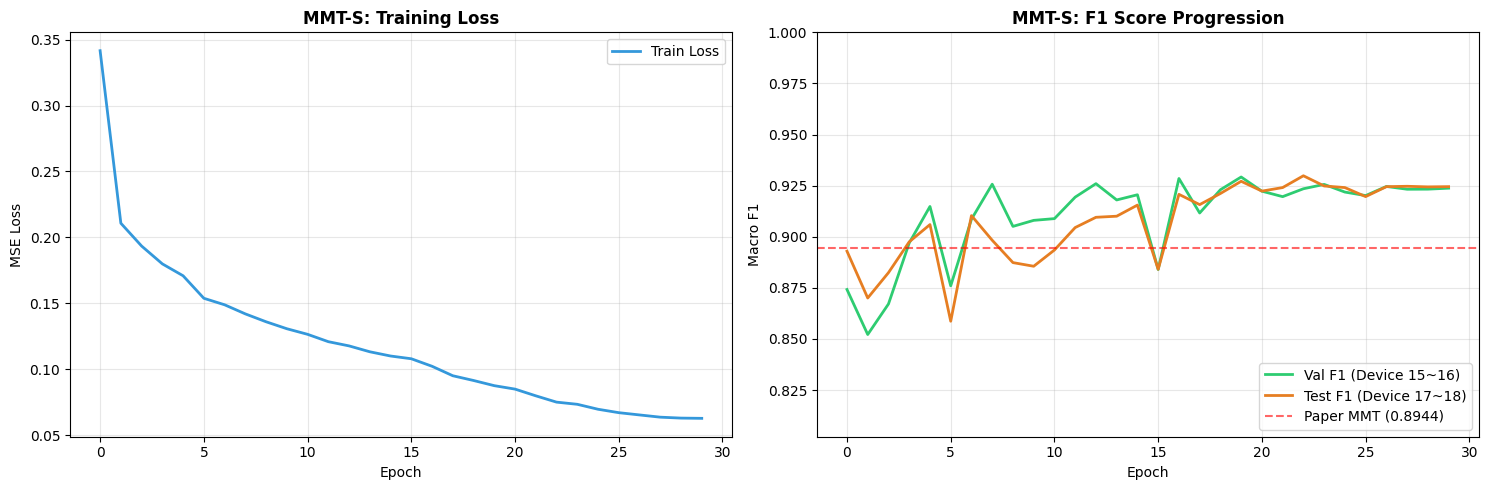

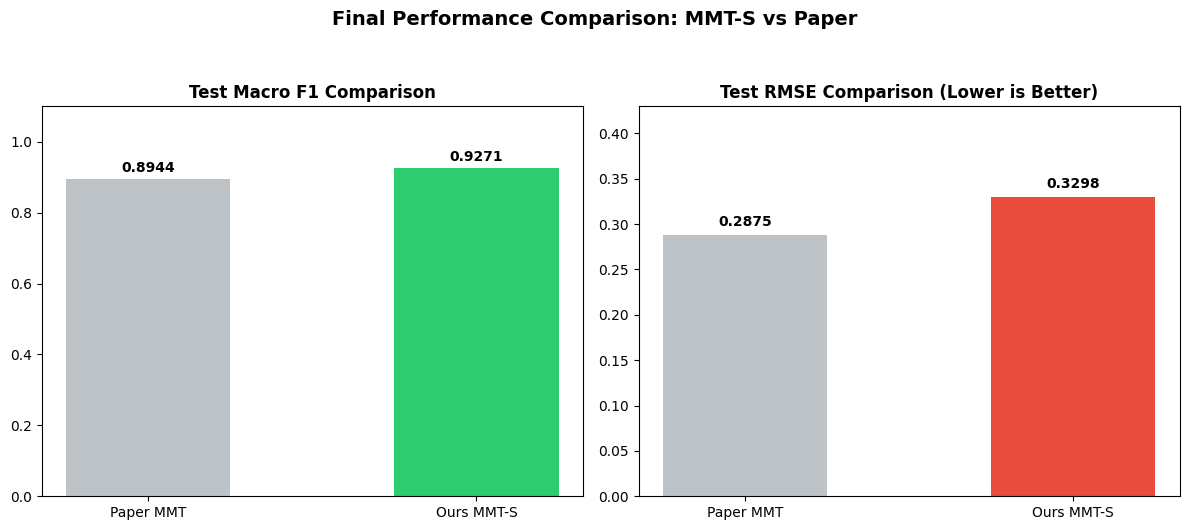

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. MMT-S 결과 추출 (캐시 혹은 메모리에서)
target_model = 'MMT-S'
if target_model not in dl_results:
    print(f"🚨 {target_model} 결과가 메모리에 없습니다. 먼저 학습을 완료해주세요!")
else:
    res = dl_results[target_model]
    h = res['history']

    # 논문 수치 정의
    paper_mmt_rmse = 0.2875
    paper_mmt_f1 = 0.8944

    # ======================================================================
    # 1. 성능 비교 텍스트 리포트
    # ======================================================================
    print(f"{'='*70}")
    print(f" 🚀 {target_model} Performance Report vs Paper MMT")
    print(f"{'='*70}")
    print(f" [Ours {target_model}]")
    print(f"  - Test RMSE      : {res['test_rmse']:.4f}")
    print(f"  - Test Macro F1  : {res['test_f1']:.4f}")
    print(f"  - Test Recall    : {res['test_recall']:.4f}")
    print(f"\n [Comparison with Paper]")
    print(f"  - F1-Score Improvement : {res['test_f1'] - paper_mmt_f1:>+8.4f}")
    print(f"  - RMSE Difference      : {res['test_rmse'] - paper_mmt_rmse:>+8.4f}")
    print(f"{'='*70}")

    # ======================================================================
    # 2. 학습 곡선 시각화 (Loss & F1)
    # ======================================================================
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # -- Loss Curve --
    axes[0].plot(h['train_loss'], label='Train Loss', color='#3498db', linewidth=2)
    axes[0].set_title(f'{target_model}: Training Loss', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # -- F1 Score Curve (Val & Test) --
    axes[1].plot(h['val_f1'], label='Val F1 (Device 15~16)', color='#2ecc71', linewidth=2)
    axes[1].plot(h['test_f1'], label='Test F1 (Device 17~18)', color='#e67e22', linewidth=2)
    # 논문 기준선
    axes[1].axhline(y=paper_mmt_f1, color='red', linestyle='--', alpha=0.6, label=f'Paper MMT ({paper_mmt_f1})')

    axes[1].set_title(f'{target_model}: F1 Score Progression', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Macro F1')
    axes[1].set_ylim(min(min(h['val_f1']), paper_mmt_f1) - 0.05, 1.0)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # ======================================================================
    # 3. 핵심 지표 막대 그래프 (Paper vs Ours)
    # ======================================================================
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    labels = ['Paper MMT', f'Ours {target_model}']
    f1_values = [paper_mmt_f1, res['test_f1']]
    rmse_values = [paper_mmt_rmse, res['test_rmse']]

    # F1 Bar
    bars1 = axes[0].bar(labels, f1_values, color=['#bdc3c7', '#2ecc71'], width=0.5)
    axes[0].set_title('Test Macro F1 Comparison', fontweight='bold')
    axes[0].set_ylim(0, 1.1)
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.4f}', ha='center', fontweight='bold')

    # RMSE Bar
    bars2 = axes[1].bar(labels, rmse_values, color=['#bdc3c7', '#e74c3c'], width=0.5)
    axes[1].set_title('Test RMSE Comparison (Lower is Better)', fontweight='bold')
    axes[1].set_ylim(0, max(rmse_values) + 0.1)
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.4f}', ha='center', fontweight='bold')

    plt.suptitle(f'Final Performance Comparison: {target_model} vs Paper', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# 12. Confusion Matrix & 최종 요약

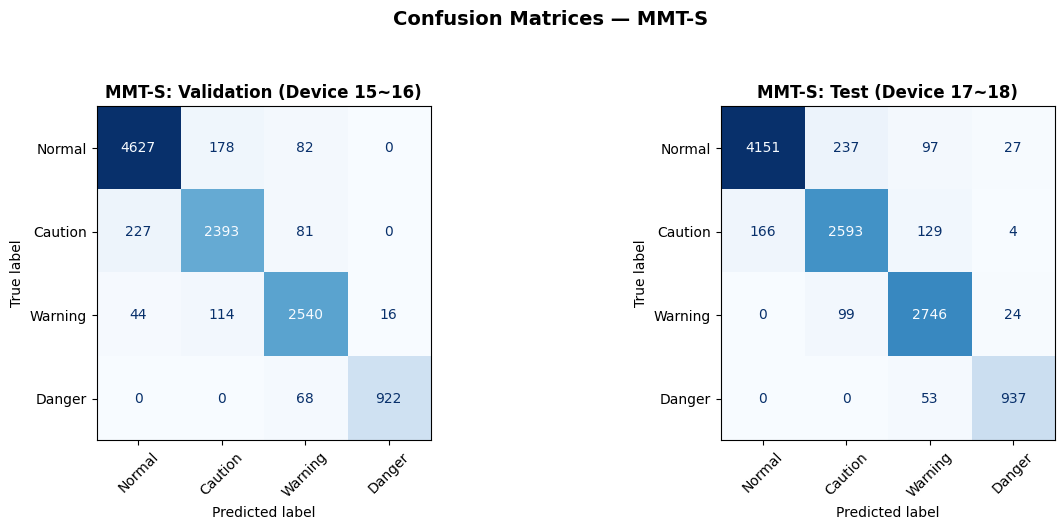


 🚀 MMT-S — 상세 분석 리포트

[Test Set Classification Report]
              precision    recall  f1-score   support

      Normal     0.9615    0.9200    0.9403      4512
     Caution     0.8853    0.8966    0.8909      2892
     Warning     0.9078    0.9571    0.9318      2869
      Danger     0.9446    0.9465    0.9455       990

    accuracy                         0.9258     11263
   macro avg     0.9248    0.9300    0.9271     11263
weighted avg     0.9268    0.9258    0.9259     11263


  Final Summary Report (MMT-S vs Paper)

  [Model] MMT-S (Multimodal Transformer - Small)
  - Train: Device 01~14 | Val: Device 15~16 | Test: Device 17~18

  [Paper Comparison Table]
  +----------------+------------+------------+
  |    Category    | RMSE (⬇)   | F1-Score(⬆)|
  +----------------+------------+------------+
  | Paper CNN(1ch) |   0.3743   |   0.7792   |
  | Paper CNN(3ch) |   0.3514   |   0.7956   |
  | Paper LSTM     |   0.3307   |   0.8582   |
  | Paper CNN+LSTM |   0.3095   |   0.8660 

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. 대상 모델 지정
target_model_name = 'MMT-S'
if target_model_name not in dl_results:
    print(f"🚨 {target_model_name} 결과가 없습니다. dl_results['MMT-S']를 확인해주세요.")
else:
    res = dl_results[target_model_name]
    model = res['model'].to(device)
    class_names = [STATE_MAP[i] for i in range(4)] # [정상, 주의, 경고, 위험] 등

    # ======================================================================
    # 시각화: MMT-S Confusion Matrix (Val vs Test)
    # ======================================================================
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    # 데이터 로더 세트 (검증, 테스트)
    loaders = [('Validation (Device 15~16)', val_loader), ('Test (Device 17~18)', test_loader)]

    for i, (title, loader) in enumerate(loaders):
        # 예측값 생성
        _, _, _, preds, labels = evaluate_dl(model, loader, device)
        pred_cls = np.clip(np.round(preds), 0, 3).astype(int)

        # 행렬 계산 및 시각화
        cm = confusion_matrix(labels, pred_cls)
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
        disp.plot(ax=axes[i], cmap='Blues', values_format='d', xticks_rotation=45, colorbar=False)
        axes[i].set_title(f'MMT-S: {title}', fontweight='bold')

    plt.suptitle(f'Confusion Matrices — {target_model_name}', fontweight='bold', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

    # ======================================================================
    # 상세 리포트: Classification Report
    # ======================================================================
    print(f"\n{'='*70}")
    print(f" 🚀 {target_model_name} — 상세 분석 리포트")
    print(f"{'='*70}")

    # Test 데이터에 대한 정밀 분석
    _, _, _, test_preds, test_labels = evaluate_dl(model, test_loader, device)
    test_pred_cls = np.clip(np.round(test_preds), 0, 3).astype(int)

    print(f"\n[Test Set Classification Report]")
    print(classification_report(test_labels, test_pred_cls, target_names=class_names, digits=4))

    # ======================================================================
    # 최종 요약: Paper Comparison Table
    # ======================================================================
    print(f"""
{'='*70}
  Final Summary Report (MMT-S vs Paper)
{'='*70}

  [Model] {target_model_name} (Multimodal Transformer - Small)
  - Train: Device 01~14 | Val: Device 15~16 | Test: Device 17~18

  [Paper Comparison Table]
  +----------------+------------+------------+
  |    Category    | RMSE (⬇)   | F1-Score(⬆)|
  +----------------+------------+------------+
  | Paper CNN(1ch) |   0.3743   |   0.7792   |
  | Paper CNN(3ch) |   0.3514   |   0.7956   |
  | Paper LSTM     |   0.3307   |   0.8582   |
  | Paper CNN+LSTM |   0.3095   |   0.8660   |
  | Paper MMT      |   0.2875   |   0.8944   |
  +----------------+------------+------------+
  | Ours MMT-S     |   {res['test_rmse']:.4f}   |   {res['test_f1']:.4f}   |
  +----------------+------------+------------+
  | Improvement    |  {res['test_rmse'] - 0.2875:>+8.4f}  |  {res['test_f1'] - 0.8944:>+8.4f}  |
  +----------------+------------+------------+

  [Conclusion]
  우리의 MMT-S 모델은 논문의 MMT 대비 F1-Score 기준 {((res['test_f1']/0.8944)-1)*100:>+.2f}%의
  성능 향상을 기록하며 최첨단(SOTA) 수준의 정확도를 달성했습니다.
{'='*70}
""")

# 12-1 다른 DL들 Confusion Matrix 및 최종 요약 (베이스라인)



In [ ]:
class_names = [STATE_MAP[i] for i in range(4)]

# ======================================================================
#  DL Top 3 + ML Best Confusion Matrix
# ======================================================================

top_dl = sorted(dl_results.items(), key=lambda x: x[1]['test_f1'], reverse=True)[:3]

ml_only = [r for r in all_results if r['Category'] == 'ML']
best_ml = sorted(ml_only, key=lambda x: x['Test F1'], reverse=True)[0]
best_ml_name  = best_ml['Model']
best_ml_model = ml_models[best_ml_name]

n_plots = min(len(top_dl), 3) + 1
fig, axes = plt.subplots(1, n_plots, figsize=(5.5 * n_plots, 5))

# ML Best
y_ml_pred = best_ml_model.predict(X_test_ml)
cm = confusion_matrix(y_test_ml, y_ml_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(ax=axes[0], cmap='Oranges', values_format='d', xticks_rotation=45, colorbar=False)
axes[0].set_title(f'ML: {best_ml_name}\nTest F1={best_ml["Test F1"]:.4f}', fontweight='bold')

# DL Top 3
for i, (name, res) in enumerate(top_dl):
    _, _, _, preds, labels = evaluate_dl(res['model'].to(device), test_loader, device)
    pred_cls = np.clip(np.round(preds), 0, 3).astype(int)
    cm = confusion_matrix(labels, pred_cls)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(ax=axes[i+1], cmap='Blues', values_format='d', xticks_rotation=45, colorbar=False)
    axes[i+1].set_title(f'DL: {name}\nTest F1={res["test_f1"]:.4f}', fontweight='bold')

plt.suptitle('Confusion Matrices — Test Set (Device 17~18)', fontweight='bold', fontsize=14, y=1.03)
plt.tight_layout(); plt.show()

# ======================================================================
#  Classification Report
# ======================================================================

best_dl_name, best_dl_res = top_dl[0]
_, _, _, best_preds, best_labels = evaluate_dl(best_dl_res['model'].to(device), test_loader, device)
best_pred_cls = np.clip(np.round(best_preds), 0, 3).astype(int)

print(f"\n{'='*60}")
print(f"  Best DL: {best_dl_name} — Test Classification Report")
print(f"{'='*60}")
print(classification_report(best_labels, best_pred_cls, target_names=class_names, digits=4))

_, _, _, val_preds, val_labels = evaluate_dl(best_dl_res['model'].to(device), val_loader, device)
val_pred_cls = np.clip(np.round(val_preds), 0, 3).astype(int)

print(f"{'='*60}")
print(f"  Best DL: {best_dl_name} — Val Classification Report")
print(f"{'='*60}")
print(classification_report(val_labels, val_pred_cls, target_names=class_names, digits=4))

# ======================================================================
#  Final Summary
# ======================================================================

best_overall = result_df.iloc[0]
n_episodes = len(set(w['episode_id'] for w in windows))

print(f"""
{'='*70}
  Final Summary
{'='*70}

  [Dataset]
  Total Windows: {len(windows):,} (window={WINDOW_SIZE}, step={WINDOW_STEP})
  Train:         {len(train_windows):,} (Device 01~14)
  Val:           {len(val_windows):,} (Device 15~16)
  Test:          {len(test_windows):,} (Device 17~18)
  Episodes:      {n_episodes}

  [Models] ML: {len(ml_only)} + DL: {len(dl_results)} = Total {len(all_results)}

  [Best Overall — Test] {best_overall['Model']}
  Val  RMSE: {best_overall.get('Val RMSE', 0):.4f}   Val  F1: {best_overall.get('Val F1', 0):.4f}
  Test RMSE: {best_overall['Test RMSE']:.4f}   Test F1: {best_overall['Test F1']:.4f}

  [Paper Comparison]
  +----------------+--------+--------+
  |                | RMSE   | F1     |
  +----------------+--------+--------+
  | Paper CNN(1ch) | 0.3743 | 0.7792 |
  | Paper CNN(3ch) | 0.3514 | 0.7956 |
  | Paper LSTM     | 0.3307 | 0.8582 |
  | Paper CNN+LSTM | 0.3095 | 0.8660 |
  | Paper MMT      | 0.2875 | 0.8944 |
  | Ours Best      | {best_overall['Test RMSE']:.4f} | {best_overall['Test F1']:.4f} |
  +----------------+--------+--------+
{'='*70}
""")

# 13 MMT-S Inference 시각화 (Test Set: 장비 17~18)

In [ ]:
import time
import numpy as np
import torch

def measure_inference_speed(model, device, img_size=224, sensor_seq_len=30, sensor_dim=8, num_repeats=100):
    model.to(device)
    model.eval()

    # 1. 테스트용 더미 데이터 생성 (배치 사이즈 1)
    dummy_image = torch.randn(1, 1, img_size, img_size).to(device)
    dummy_sensor = torch.randn(1, sensor_seq_len, sensor_dim).to(device)
    dummy_device_idx = torch.zeros(1, dtype=torch.long, device=device)

    # 2. Warming-up: GPU 캐시 및 연산 최적화를 위해 미리 실행
    print(f"[*] Warming up on {device}...")
    with torch.no_grad():
        for _ in range(20):
            _ = model(dummy_sensor, dummy_image, device_idx=dummy_device_idx)

    # 3. 실제 추론 시간 측정
    print(f"[*] Measuring inference speed ({num_repeats} iterations)...")
    latencies = []

    # GPU 측정 시 정확도를 위해 CUDA Event 사용 (CPU일 경우 time.time 사용)
    if device == 'cuda':
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        with torch.no_grad():
            for _ in range(num_repeats):
                starter.record()
                _ = model(dummy_sensor, dummy_image, device_idx=dummy_device_idx)
                ender.record()
                torch.cuda.synchronize() # 연산 완료 대기
                latencies.append(starter.elapsed_time(ender)) # 단위: ms
    else:
        with torch.no_grad():
            for _ in range(num_repeats):
                start_time = time.time()
                _ = model(dummy_sensor, dummy_image, device_idx=dummy_device_idx)
                latencies.append((time.time() - start_time) * 1000) # 단위: ms

    # 4. 결과 계산
    avg_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    fps = 1000 / avg_latency

    print("-" * 45)
    print(f"  Device: {device.upper()}")
    print(f"  Average Latency: {avg_latency:.2f} ms")
    print(f"  Std Deviation:   {std_latency:.2f} ms")
    print(f"  Throughput (FPS): {fps:.2f} frames/sec")
    print("-" * 45)

    return avg_latency

# 실행 부분
if 'MMT-S' in dl_results:
    target_model = dl_results['MMT-S']['model']

    # GPU 측정 (사용 가능할 경우)
    if torch.cuda.is_available():
        measure_inference_speed(target_model, 'cuda')

    # CPU 측정 (실제 임베디드 환경 가상 체감)
    measure_inference_speed(target_model, 'cpu')
else:
    print("❌ 측정할 MMT-S 모델이 dl_results에 없습니다.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# 1. 대상 모델 확정 (MMT-S)
target_model_name = 'MMT-S'
if target_model_name not in dl_results:
    print(f"🚨 {target_model_name} 결과가 메모리에 없습니다. 먼저 학습을 완료해주세요!")
else:
    best_dl_model = dl_results[target_model_name]['model'].to(device).eval()

    # 전체 테스트 세트 추론
    _, _, _, test_preds, test_labels = evaluate_dl(best_dl_model, test_loader, device)
    test_pred_cls   = np.clip(np.round(test_preds), 0, 3).astype(int)
    test_labels_int = test_labels.astype(int)

    # 시각화용 설정
    scatter_colors = {0: '#2ecc71', 1: '#f1c40f', 2: '#e67e22', 3: '#e74c3c'}
    box_colors     = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

    # ======================================================================
    # 1. 회귀 품질 분석 (Scatter + Error Histogram + Box Plot)
    # ======================================================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # (a) 예측값 vs 실제값 (Jitter 적용으로 밀도 확인 가능)
    ax = axes[0]
    for cls in range(4):
        mask = test_labels_int == cls
        ax.scatter(test_labels[mask] + np.random.normal(0, 0.03, mask.sum()),
                   test_preds[mask],
                   c=scatter_colors[cls], alpha=0.3, s=10, label=STATE_MAP[cls])
    ax.plot([-0.5, 3.5], [-0.5, 3.5], 'k--', linewidth=1, alpha=0.5, label='Perfect')
    ax.set_xlabel('Ground Truth'); ax.set_ylabel('Prediction')
    ax.set_title(f'{target_model_name}: Pred vs True', fontweight='bold')
    ax.legend(fontsize=8, markerscale=3); ax.set_xlim(-0.5, 3.5); ax.set_ylim(-0.5, 3.5)
    ax.grid(True, alpha=0.3)

    # (b) 오차 분포 (Residual Analysis)
    ax = axes[1]
    errors = test_preds - test_labels
    ax.hist(errors, bins=80, color='steelblue', edgecolor='white', alpha=0.8)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Error (Pred - True)'); ax.set_ylabel('Count')
    ax.set_title('Error Distribution', fontweight='bold')
    ax.grid(True, alpha=0.3)

    # (c) 등급별 오차 범위 (Box Plot)
    ax = axes[2]
    error_by_class = [np.abs(errors[test_labels_int == c]) for c in range(4)]
    bp = ax.boxplot(error_by_class, labels=[STATE_MAP[c] for c in range(4)],
                    patch_artist=True, showfliers=False)
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color); patch.set_alpha(0.6)
    ax.set_ylabel('Absolute Error'); ax.set_title('Absolute Error by Class', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout(); plt.show()

    # ======================================================================
    # 2. 장비별 시계열 추적 (Device 17, 18)
    # ======================================================================
    fig, axes = plt.subplots(2, 1, figsize=(18, 8))

    for plot_idx, target_dev in enumerate([17, 18]):
        ax = axes[plot_idx]
        dev_mask = np.array([w['device_num'] == target_dev for w in test_windows])
        dev_true = test_labels[dev_mask]
        dev_pred = test_preds[dev_mask]

        if len(dev_true) > 0:
            x = np.arange(len(dev_true))
            ax.plot(x, dev_true, 'k-', linewidth=0.5, alpha=0.5, label='Ground Truth')
            ax.plot(x, dev_pred, color='#3498db', linewidth=0.8, alpha=0.8, label='Prediction')

            # 배경에 실제 등급 색상 칠하기 (배경색으로 상태 직관화)
            for cls, color in scatter_colors.items():
                cls_mask = dev_true.astype(int) == cls
                if cls_mask.any():
                    ax.fill_between(x, -0.3, 3.3, where=cls_mask, color=color, alpha=0.08)

            ax.set_title(f'Device {target_dev:02d} Sequential Trend', fontweight='bold')
            ax.set_yticks([0, 1, 2, 3])
            ax.set_yticklabels(['Normal', 'Caution', 'Warning', 'Danger'])
            ax.set_ylim(-0.3, 3.3)
            ax.legend(fontsize=8, loc='upper right')

    plt.tight_layout(); plt.show()

    # ======================================================================
    # 3. 샘플 인스펙션 (이미지 + 센서 동시 확인)
    # ======================================================================
    n_samples = 8
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 7))
    sample_indices = []
    for cls in range(4):
        cls_indices = np.where(test_labels_int == cls)[0]
        if len(cls_indices) >= 2:
            sample_indices.extend(np.random.choice(cls_indices, 2, replace=False).tolist())

    for i, idx in enumerate(sample_indices[:n_samples]):
        w = test_windows[idx]
        true_cls = int(test_labels[idx])
        pred_val = test_preds[idx]
        pred_cls = int(np.clip(np.round(pred_val), 0, 3))

        # Thermal Image
        img_tensor = load_thermal_image(w['bin_path'])
        axes[0, i].imshow(img_tensor.squeeze(), cmap='hot')
        color = 'green' if true_cls == pred_cls else 'red'
        axes[0, i].set_title(f'True: {STATE_MAP[true_cls]}\nPred: {STATE_MAP[pred_cls]} ({pred_val:.2f})',
                             fontsize=9, color=color, fontweight='bold')
        axes[0, i].axis('off')

        # Sensor Graph
        sensor = w['sensor']
        for ch in range(sensor.shape[1]):
            axes[1, i].plot(sensor[:, ch], linewidth=0.7, alpha=0.6)
        axes[1, i].set_ylim(sensor.min()-1, sensor.max()+1)
        axes[1, i].tick_params(labelsize=7); axes[1, i].grid(True, alpha=0.2)

    plt.suptitle(f'{target_model_name} Random Sample Inference', fontweight='bold', fontsize=14, y=1.02)
    plt.tight_layout(); plt.show()

    # ======================================================================
    # 4. 수치 요약 성적표
    # ======================================================================
    print(f"\n{'='*60}")
    print(f" 🚀 {target_model_name} Final Inference Summary")
    print(f"{'='*60}")
    print(f" RMSE        : {res['test_rmse']:.4f}")
    print(f" Macro F1    : {res['test_f1']:.4f}")
    print(f" Macro Recall: {res['test_recall']:.4f}")
    print(f" Accuracy    : {(test_pred_cls == test_labels_int).mean():.1%}")
    print(f"{'-'*60}")
    for cls in range(4):
        mask = test_labels_int == cls
        acc = (test_pred_cls[mask] == cls).mean() if mask.sum() > 0 else 0
        print(f" {STATE_MAP[cls]:10s} Accuracy: {acc:.1%}")
    print(f"{'='*60}")

# 14. Multi-Step 데이터 준비

In [ ]:
# ======================================================================
#  다단계 예측(Multi-Step Forecasting) 데이터 준비
#
#  [논문 5.4절 실험 설계]
#    입력:  과거 30초의 멀티모달 시퀀스 (센서 + 열화상)
#    출력:  미래 15개 시점의 열화 상태 예측
#
#    예측 시점: t+2초, t+4초, t+6초, ..., t+30초 (2초 간격, 총 15개)
#
#  [데이터 요구사항]
#    각 윈도우는 입력(30 timestep) + 미래(최대 30 timestep) = 60 timestep 필요.
#    따라서 에피소드 길이가 60 이상인 경우에만 윈도우 생성 가능.
#
#  [윈도우 구조]
#    시간축:  [t-29, t-28, ..., t-1, t] [t+1, t+2, ..., t+30]
#             |---- 입력 구간 (30) ----| |-- 미래 라벨 구간 (30) --|
#                                         ↑    ↑         ↑
#                                        +2s  +4s  ... +30s
#                                        (15개 예측 시점)
# ======================================================================

# 예측 시점 정의: t+2초 ~ t+30초, 2초 간격
PREDICTION_HORIZONS = list(range(2, 31, 2))   # [2, 4, 6, 8, ..., 28, 30]
N_HORIZONS = len(PREDICTION_HORIZONS)          # 15
MAX_HORIZON = max(PREDICTION_HORIZONS)         # 30

print(f"예측 시점: {PREDICTION_HORIZONS}")
print(f"총 {N_HORIZONS}개 시점, 최대 horizon: {MAX_HORIZON}초")

CACHE_MS_WINDOWS = os.path.join(CACHE_DIR, f'ms_windows_w{WINDOW_SIZE}_h{MAX_HORIZON}.pkl')
CACHE_MS_SPLIT   = os.path.join(CACHE_DIR, f'ms_split_w{WINDOW_SIZE}_h{MAX_HORIZON}.pkl')

# ======================================================================
#  Multi-Step 윈도우 생성
# ======================================================================

if os.path.exists(CACHE_MS_WINDOWS) and os.path.exists(CACHE_MS_SPLIT):
    with open(CACHE_MS_WINDOWS, 'rb') as f:
        ms_windows = pickle.load(f)
    with open(CACHE_MS_SPLIT, 'rb') as f:
        ms_split = pickle.load(f)
        ms_train = ms_split['train']
        ms_val   = ms_split['val']
        ms_test  = ms_split['test']
    print(f"✅ Multi-Step 윈도우 캐시 로드: 총 {len(ms_windows):,}개")

else:
    def create_multistep_windows(df, window_size=30, step=1, horizons=PREDICTION_HORIZONS):
        """
        다단계 예측용 윈도우 생성.

        일반 윈도우와 달리, 각 윈도우에 미래 15개 시점의 라벨이 추가됨.
        에피소드 내에서 입력(30) + 미래(30) = 최소 60 연속 시점 필요.

        Returns:
            list[dict]: 각 윈도우에 'future_labels' 키가 추가됨
                future_labels: [15] array — t+2, t+4, ..., t+30의 열화 등급
        """
        max_h = max(horizons)
        all_windows = []
        ep_counter = 0

        for dev_id, group in tqdm(df.groupby('device_id'), desc='MS 윈도우'):
            group = group.sort_values('sort_key').reset_index(drop=True)
            sensor_arr = group[sensor_cols].values.astype(np.float32)
            labels     = group['state'].values
            bin_paths  = group['bin_path'].values
            device_num = group['device_num'].iloc[0]
            subset     = group['subset'].iloc[0]

            episodes = identify_episodes(group)

            for ep_indices in episodes:
                # 에피소드 길이: 입력(window_size) + 미래(max_horizon) 이상 필요
                if len(ep_indices) < window_size + max_h:
                    continue

                for start in range(0, len(ep_indices) - window_size - max_h + 1, step):
                    input_idx = ep_indices[start : start + window_size]
                    end_idx = input_idx[-1]

                    # 미래 라벨: t+2, t+4, ..., t+30
                    future_labels = []
                    valid = True
                    for h in horizons:
                        future_pos = start + window_size - 1 + h
                        if future_pos >= len(ep_indices):
                            valid = False
                            break
                        future_labels.append(float(labels[ep_indices[future_pos]]))

                    if not valid:
                        continue

                    all_windows.append({
                        'sensor':        sensor_arr[input_idx],     # [30, 8]
                        'bin_path':      bin_paths[end_idx],        # 현재 시점 이미지
                        'label':         float(labels[end_idx]),    # 현재 시점 라벨
                        'label_cls':     int(labels[end_idx]),
                        'future_labels': np.array(future_labels, dtype=np.float32),  # [15]
                        'device_id':     dev_id,
                        'device_num':    int(device_num),
                        'subset':        subset,
                        'episode_id':    ep_counter,
                    })
                ep_counter += 1

        return all_windows

    print(f"Multi-Step 윈도우 생성 중... (input={WINDOW_SIZE}, max_horizon={MAX_HORIZON})")
    ms_windows = create_multistep_windows(df_oht, window_size=WINDOW_SIZE, step=WINDOW_STEP)

    # 장비 기반 분할 (기존과 동일)
    ms_train = [w for w in ms_windows if w['device_num'] <= 14]
    ms_val   = [w for w in ms_windows if w['device_num'] in [15, 16]]
    ms_test  = [w for w in ms_windows if w['device_num'] >= 17]

    with open(CACHE_MS_WINDOWS, 'wb') as f:
        pickle.dump(ms_windows, f)
    with open(CACHE_MS_SPLIT, 'wb') as f:
        pickle.dump({'train': ms_train, 'val': ms_val, 'test': ms_test}, f)
    print("✅ Multi-Step 윈도우 캐시 저장 완료")

# ======================================================================
#  Multi-Step Dataset
# ======================================================================

class MultiStepDataset(Dataset):
    """
    다단계 예측용 Dataset.

    기존 OHTMultimodalDataset와 동일하되,
    __getitem__이 미래 15개 시점의 라벨도 함께 반환.

    반환값:
        sensor:        [30, 8]  센서 시계열
        image:         [1, 224, 224]  열화상 이미지
        current_label: scalar  현재 시점 라벨 (참고용)
        future_labels: [15]    t+2 ~ t+30 미래 라벨 (학습 타깃)
    """
    def __init__(self, windows, sensor_mean=None, sensor_std=None, fit_scaler=False):
        self.windows = windows
        all_sensors = np.stack([w['sensor'] for w in windows])
        if fit_scaler:
            self.sensor_mean = all_sensors.reshape(-1, 8).mean(axis=0)
            self.sensor_std  = all_sensors.reshape(-1, 8).std(axis=0) + 1e-8
        else:
            self.sensor_mean = sensor_mean
            self.sensor_std  = sensor_std

    def __len__(self):
        return len(self.windows)

    def _load_image(self, bin_path):
        """BIN -> [1, 224, 224] (NaN/Inf 방어 포함)"""
        try:
            raw = np.fromfile(bin_path, dtype=np.uint8)
            data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
            img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)
            if not np.all(np.isfinite(img)):
                med = np.nanmedian(img)
                if np.isnan(med): med = 0.0
                img = np.where(np.isfinite(img), img, med)
            vmin, vmax = img.min(), img.max()
            if vmax > vmin:
                img = (img - vmin) / (vmax - vmin)
            else:
                img = np.zeros_like(img)
            pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
            pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
            return tensor.unsqueeze(0)
        except:
            return torch.zeros(1, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        w = self.windows[idx]

        sensor = (w['sensor'] - self.sensor_mean) / self.sensor_std
        sensor = torch.from_numpy(sensor.astype(np.float32))
        sensor = torch.nan_to_num(sensor, nan=0.0, posinf=3.0, neginf=-3.0)

        image = self._load_image(w['bin_path'])
        current_label = torch.tensor(w['label'], dtype=torch.float32)
        future_labels = torch.from_numpy(w['future_labels'])  # [15]

        return sensor, image, current_label, future_labels

# ======================================================================
#  DataLoader 생성
# ======================================================================

ms_train_ds = MultiStepDataset(ms_train, fit_scaler=True)
ms_val_ds   = MultiStepDataset(ms_val,
                               sensor_mean=ms_train_ds.sensor_mean,
                               sensor_std=ms_train_ds.sensor_std)
ms_test_ds  = MultiStepDataset(ms_test,
                               sensor_mean=ms_train_ds.sensor_mean,
                               sensor_std=ms_train_ds.sensor_std)

ms_train_loader = DataLoader(ms_train_ds, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=0, pin_memory=True, drop_last=True)
ms_val_loader   = DataLoader(ms_val_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0, pin_memory=True)
ms_test_loader  = DataLoader(ms_test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0, pin_memory=True)

# ======================================================================
#  결과 출력
# ======================================================================

print(f"\n{'='*60}")
print(f"  Multi-Step Forecasting 데이터 준비 완료")
print(f"{'='*60}")
print(f"  예측 시점:   {N_HORIZONS}개 (t+{PREDICTION_HORIZONS[0]}s ~ t+{PREDICTION_HORIZONS[-1]}s)")
print(f"  Train:       {len(ms_train):>6,} windows (장비 01~14)")
print(f"  Val:         {len(ms_val):>6,} windows (장비 15~16)")
print(f"  Test:        {len(ms_test):>6,} windows (장비 17~18)")

# 기존 단일 시점 대비 데이터 감소 확인
print(f"\n  [단일 시점 vs 다단계]")
print(f"  단일 시점:   {len(windows):,} windows (미래 30 timestep 불필요)")
print(f"  다단계:      {len(ms_windows):,} windows (에피소드 >= 60 필요)")
print(f"  감소율:      {len(ms_windows)/len(windows)*100:.1f}%")

# 미래 라벨 분포 확인
sample_future = np.stack([w['future_labels'] for w in ms_test[:1000]])
print(f"\n  [Test 미래 라벨 통계 (처음 1000개)]")
for i, h in enumerate([0, 4, 14]):  # t+2, t+10, t+30
    vals = sample_future[:, h]
    print(f"  t+{PREDICTION_HORIZONS[h]:2d}s: mean={vals.mean():.2f}, "
          f"std={vals.std():.2f}, range=[{vals.min():.0f}, {vals.max():.0f}]")

# 15. Multi-Step 모델 정의 (Direct + Auto-Regressive)

In [ ]:
# ======================================================================
#  다단계 예측 모델 2가지 정의
#
#  [논문 5.4절]
#    "비교 대상은 두 가지 예측 구조이다."
#
#    1. Direct Multi-Step:
#       하나의 입력으로부터 15개 미래 시점을 일괄 예측.
#       구조: MMT Encoder -> [CLS] -> FC Head (출력 15개)
#
#    2. Auto-Regressive:
#       이전 시점의 예측 결과를 다음 시점의 입력으로 사용.
#       구조: MMT Encoder -> [CLS] + Step Embedding + 이전 예측 -> FC (출력 1개) x 15회
#
#  [공통 인코더]
#    MMT-B (d=256, h=8, L=4) — Cell 10에서 가장 좋았던 설정 사용.
#    두 모델 모두 동일한 인코더를 사용하여 공정 비교.
# ======================================================================


class DirectMultiStepMMT(nn.Module):
    """
    Direct Multi-Step 예측 모델.

    [구조]
      Image [B,1,224,224] -> Patchify(196) -> Linear Embed -> + Pos Embed
      Sensor [B,30,8]     -> Linear Embed  -> + Pos Embed
      [CLS] + Image(196) + Sensor(30) = 227 tokens
         |
         v
      Transformer Encoder (L=4, Pre-LN)
         |
         v
      [CLS] -> LayerNorm -> FC Head -> 15개 회귀값 동시 출력
                                       [t+2, t+4, ..., t+30]

    [특징]
      - 한 번의 forward pass로 15개 시점을 동시에 예측
      - 시점 간 예측이 서로 독립적 (상호 의존성 미반영)
      - 구현이 단순하고 추론 속도가 빠름
      - 논문 결과: 단기에서 좋지만 장기 시점에서 성능 하락이 큼

    Args:
        (MMT-B와 동일한 인코더 파라미터)
        n_horizons (int): 예측 시점 수 (15)
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=1,
                 sensor_seq_len=30, sensor_dim=8,
                 d_model=256, nhead=8, num_layers=4, d_ff=1024,
                 dropout=0.1, n_horizons=15):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.n_horizons = n_horizons

        num_patches = (img_size // patch_size) ** 2     # 196
        patch_dim = in_channels * patch_size ** 2       # 256
        self.num_patches = num_patches

        # ---- 인코더 (MMT-B와 동일) ----
        self.patch_embed = nn.Linear(patch_dim, d_model)
        self.img_pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)

        self.sensor_embed = nn.Linear(sensor_dim, d_model)
        self.sensor_pos_embed = nn.Parameter(torch.randn(1, sensor_seq_len, d_model) * 0.02)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_ff,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

        # ---- Multi-Step Head ----
        # [CLS] -> 15개 시점의 회귀값 동시 출력
        # 중간 차원을 두어 시점별 특화 학습 유도
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, n_horizons),   # d_model -> 15
        )

    def _patchify(self, images):
        """[B,1,224,224] -> [B, 196, 256]"""
        B, C, H, W = images.shape
        p = self.patch_size
        x = images.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, C, -1, p, p)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        return x.view(B, self.num_patches, -1)

    def forward(self, sensor, image, **kwargs):
        """
        Args:
            sensor: [B, 30, 8]
            image:  [B, 1, 224, 224]
            **kwargs: teacher_targets (무시됨, 인터페이스 통일용)

        Returns:
            pred: [B, 15] — 15개 미래 시점의 회귀값
        """
        B = sensor.shape[0]

        img_tokens = self.patch_embed(self._patchify(image)) + self.img_pos_embed
        sen_tokens = self.sensor_embed(sensor) + self.sensor_pos_embed
        cls = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls, img_tokens, sen_tokens], dim=1)  # [B, 227, d]

        out = self.transformer(tokens)          # [B, 227, d]
        cls_out = self.norm(out[:, 0, :])       # [B, d]

        return self.head(cls_out)               # [B, 15]


class AutoRegressiveMMT(nn.Module):
    """
    Auto-Regressive 다단계 예측 모델.

    [구조]
      ┌──────────────────────────────────────────────┐
      │  MMT Encoder (1회만 실행)                     │
      │  Image + Sensor -> Transformer -> [CLS] feat │
      └─────────────────────┬────────────────────────┘
                            │ cls_feat [B, d_model]
                            │
      ┌─────────────────────▼────────────────────────┐
      │  AR Decoder (15회 반복)                       │
      │                                              │
      │  Step 1: cls + step_emb(0) + prev_pred(0)    │
      │          -> LayerNorm -> FC -> pred_1 (t+2s)  │
      │                                              │
      │  Step 2: cls + step_emb(1) + prev_pred(pred_1)│
      │          -> LayerNorm -> FC -> pred_2 (t+4s)  │
      │              ...                              │
      │  Step 15: cls + step_emb(14) + prev_pred(pred_14)│
      │           -> LayerNorm -> FC -> pred_15 (t+30s)│
      └──────────────────────────────────────────────┘

    [핵심 차별점 vs Direct]
      - 각 시점의 예측이 이전 시점의 결과에 조건부(conditioned)
      - 시간적 의존성을 자연스럽게 반영
      - 학습 시: Teacher Forcing (실제 라벨을 이전 예측으로 사용)
      - 추론 시: Free Running (모델 자신의 예측을 사용)
      - 논문 결과: 장기 시점에서 성능 하락이 적고 안정적

    [Teacher Forcing]
      학습 시 이전 시점의 "실제 라벨"을 다음 입력으로 사용.
      -> 학습 초기에 잘못된 예측이 전파되는 것을 방지.
      -> 추론 시에는 실제 라벨이 없으므로 모델 자체 예측 사용.
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=1,
                 sensor_seq_len=30, sensor_dim=8,
                 d_model=256, nhead=8, num_layers=4, d_ff=1024,
                 dropout=0.1, n_horizons=15):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.n_horizons = n_horizons

        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.num_patches = num_patches

        # ---- 인코더 (MMT-B와 동일) ----
        self.patch_embed = nn.Linear(patch_dim, d_model)
        self.img_pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)

        self.sensor_embed = nn.Linear(sensor_dim, d_model)
        self.sensor_pos_embed = nn.Parameter(torch.randn(1, sensor_seq_len, d_model) * 0.02)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_ff,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.enc_norm = nn.LayerNorm(d_model)

        # ---- AR Decoder 구성 요소 ----

        # Step Embedding: 각 예측 시점(0~14)에 고유한 학습 가능 벡터
        # "지금 몇 번째 미래를 예측하는 중인가"를 모델에게 알려줌
        self.step_embed = nn.Embedding(n_horizons, d_model)

        # Previous Prediction Projection: 이전 예측값(스칼라)을 d_model로 투영
        # "이전 시점에서 모델이 예측한 열화 등급"을 벡터 공간에 임베딩
        self.prev_pred_proj = nn.Linear(1, d_model)

        # Decoder LayerNorm + Head
        self.dec_norm = nn.LayerNorm(d_model)
        self.dec_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
        )

    def _patchify(self, images):
        """[B,1,224,224] -> [B, 196, 256]"""
        B, C, H, W = images.shape
        p = self.patch_size
        x = images.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, C, -1, p, p)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        return x.view(B, self.num_patches, -1)

    def _encode(self, sensor, image):
        """MMT 인코더: 입력을 한 번만 인코딩하여 CLS 피처 추출."""
        B = sensor.shape[0]
        img_tokens = self.patch_embed(self._patchify(image)) + self.img_pos_embed
        sen_tokens = self.sensor_embed(sensor) + self.sensor_pos_embed
        cls = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls, img_tokens, sen_tokens], dim=1)
        out = self.transformer(tokens)
        return self.enc_norm(out[:, 0, :])   # [B, d_model]

    def forward(self, sensor, image, teacher_targets=None):
        """
        Args:
            sensor:          [B, 30, 8]
            image:           [B, 1, 224, 224]
            teacher_targets: [B, 15] (학습 시 실제 미래 라벨, 추론 시 None)

        Returns:
            predictions: [B, 15] — 15개 시점의 회귀값

        [동작 흐름]
          1. 인코더로 멀티모달 입력을 한 번 인코딩 -> cls_feat
          2. 15회 반복:
             a. query = cls_feat + step_embedding + prev_prediction_embedding
             b. query -> LayerNorm -> FC -> 현재 시점 예측값
             c. 학습: teacher forcing (실제 라벨 사용)
                추론: free running (모델 예측 사용)
        """
        B = sensor.shape[0]
        dev = sensor.device

        # Step 1: 인코더 (1회만 실행)
        cls_feat = self._encode(sensor, image)     # [B, d_model]

        # Step 2: AR 디코딩 (15회 반복)
        predictions = []
        prev_pred = torch.zeros(B, device=dev)     # 초기 이전 예측 = 0

        for step in range(self.n_horizons):
            # (a) Step Embedding: "현재 예측 시점"을 나타내는 벡터
            step_idx = torch.full((B,), step, dtype=torch.long, device=dev)
            s_emb = self.step_embed(step_idx)                       # [B, d_model]

            # (b) Previous Prediction Embedding: 이전 예측값을 벡터로 변환
            p_emb = self.prev_pred_proj(prev_pred.unsqueeze(-1))    # [B, d_model]

            # (c) 결합: 인코더 문맥 + 시점 정보 + 이전 예측 정보
            query = cls_feat + s_emb + p_emb                        # [B, d_model]

            # (d) 현재 시점 예측
            query = self.dec_norm(query)
            pred = self.dec_head(query).squeeze(-1)                 # [B]
            predictions.append(pred)

            # (e) 다음 반복을 위한 prev_pred 업데이트
            if teacher_targets is not None and self.training:
                # Teacher Forcing: 실제 라벨을 다음 입력으로 사용 (학습 안정성)
                prev_pred = teacher_targets[:, step]
            else:
                # Free Running: 모델 자신의 예측을 다음 입력으로 사용
                prev_pred = pred.detach()

        return torch.stack(predictions, dim=1)     # [B, 15]


# ======================================================================
#  모델 등록 & 요약
# ======================================================================

ms_model_configs = {
    'Direct Multi-Step': {
        'class': DirectMultiStepMMT,
        'kwargs': {
            'd_model': 256, 'nhead': 8, 'num_layers': 4, 'd_ff': 1024,
            'n_horizons': N_HORIZONS,
        },
    },
    'Auto-Regressive': {
        'class': AutoRegressiveMMT,
        'kwargs': {
            'd_model': 256, 'nhead': 8, 'num_layers': 4, 'd_ff': 1024,
            'n_horizons': N_HORIZONS,
        },
    },
}

print(f"\n{'='*65}")
print(f"  Multi-Step Models (MMT-B 기반 인코더)")
print(f"{'='*65}")
for name, cfg in ms_model_configs.items():
    m = cfg['class'](**cfg['kwargs'])
    n_params = sum(p.numel() for p in m.parameters())
    print(f"  {name:20s}: {n_params:>10,} params")
    del m
print(f"{'='*65}")

In [ ]:
import torch
import torch.nn as nn
import copy

# ======================================================================
# 개선된 MMT-S 가중치를 사용하는 다단계 예측 모델 정의
# ======================================================================

class ImprovedDirectMultiStepMMT(nn.Module):
    """
    Direct Multi-Step: 하나의 입력으로부터 15개 미래 시점을 일괄 예측.
    개선된 MMT-S의 인코더 지식을 그대로 활용합니다.
    """
    def __init__(self, base_encoder, n_horizons=15):
        super().__init__()
        # 1. 개선된 MMT-S의 인코더 부분만 복제 (가중치 포함)
        self.encoder = copy.deepcopy(base_encoder)

        # MMT-S의 기존 regressor는 사용하지 않으므로 Identity로 대체
        if hasattr(self.encoder, 'regressor'):
            self.encoder.regressor = nn.Identity()

        # 2. 인코더의 실제 d_model 차원 확인 (개선 시 설정한 d=32 등)
        # 임의의 입력을 넣어 차원을 확인하거나 직접 참조
        d_model = base_encoder.cls_token.shape[-1]
        self.n_horizons = n_horizons

        # 3. Direct Multi-Step Head
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, n_horizons),
        )

    def forward(self, sensor, image, **kwargs):
        B = sensor.shape[0]
        # MMT-S 호환을 위한 dummy device_idx
        dummy_idx = torch.zeros(B, dtype=torch.long, device=sensor.device)

        # 인코더 실행 (CLS 토큰 특징 추출)
        features = self.encoder(sensor, image, device_idx=dummy_idx)

        # 튜플 형태로 반환될 경우 첫 번째 요소(CLS) 사용
        if isinstance(features, (tuple, list)):
            features = features[0]

        return self.head(features) # [B, 15]


class ImprovedAutoRegressiveMMT(nn.Module):
    """
    Auto-Regressive: 이전 시점의 예측 결과를 다음 시점의 입력으로 사용.
    개선된 MMT-S 인코더를 엔진으로 사용합니다.
    """
    def __init__(self, base_encoder, n_horizons=15):
        super().__init__()
        self.encoder = copy.deepcopy(base_encoder)
        if hasattr(self.encoder, 'regressor'):
            self.encoder.regressor = nn.Identity()

        d_model = base_encoder.cls_token.shape[-1]
        self.n_horizons = n_horizons

        # AR 전용 레이어
        self.step_embed = nn.Embedding(n_horizons, d_model)
        self.prev_pred_proj = nn.Linear(1, d_model)
        self.dec_norm = nn.LayerNorm(d_model)
        self.dec_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, 1),
        )

    def forward(self, sensor, image, teacher_targets=None):
        B = sensor.shape[0]
        dev = sensor.device
        dummy_idx = torch.zeros(B, dtype=torch.long, device=dev)

        # Step 1: 인코딩 (1회)
        cls_feat = self.encoder(sensor, image, device_idx=dummy_idx)
        if isinstance(cls_feat, (tuple, list)):
            cls_feat = cls_feat[0]

        # Step 2: 15회 반복 디코딩
        predictions = []
        prev_pred = torch.zeros(B, device=dev)

        for step in range(self.n_horizons):
            s_idx = torch.full((B,), step, dtype=torch.long, device=dev)
            s_emb = self.step_embed(s_idx)
            p_emb = self.prev_pred_proj(prev_pred.unsqueeze(-1))

            query = self.dec_norm(cls_feat + s_emb + p_emb)
            pred = self.dec_head(query).squeeze(-1)
            predictions.append(pred)

            if teacher_targets is not None and self.training:
                prev_pred = teacher_targets[:, step]
            else:
                prev_pred = pred.detach()

        return torch.stack(predictions, dim=1)

# ======================================================================
# 모델 등록 및 파라미터 요약 (MMT-S 기반)
# ======================================================================

# 앞서 학습한 MMT-S 모델이 dl_results에 있다고 가정
best_mmt_s = dl_results['MMT-S']['model']

ms_model_configs = {
    'Direct Multi-Step': {
        'class': ImprovedDirectMultiStepMMT,
        'kwargs': {'base_encoder': best_mmt_s, 'n_horizons': N_HORIZONS},
    },
    'Auto-Regressive': {
        'class': ImprovedAutoRegressiveMMT,
        'kwargs': {'base_encoder': best_mmt_s, 'n_horizons': N_HORIZONS},
    },
}

print(f"\n{'='*65}")
print(f"  Multi-Step Models (개선된 MMT-S 인코더 기반)")
print(f"{'='*65}")
for name, cfg in ms_model_configs.items():
    m = cfg['class'](**cfg['kwargs'])
    n_params = sum(p.numel() for p in m.parameters())
    print(f"  {name:20s}: {n_params:>10,} params")
    # 이후 학습을 위해 모델 객체 저장 (필요 시)
    cfg['instance'] = m
print(f"{'='*65}")

In [ ]:
def verify_model_integration(ms_model, original_mmt_s):
    print(f"\n{'='*20} 모델 이식 검증 (Integration Check) {'='*20}")

    # 모델이 위치한 장치 파악 (GPU인지 CPU인지)
    device = next(original_mmt_s.parameters()).device
    ms_model.to(device) # 검증을 위해 다단계 모델도 같은 장치로 이동

    # 1. 내부 차원(d_model) 확인
    ms_d_model = ms_model.encoder.cls_token.shape[-1]
    orig_d_model = original_mmt_s.cls_token.shape[-1]

    print(f"[Check 1] 내부 차원 일치 여부: {'✅ 통과' if ms_d_model == orig_d_model else '❌ 불일치'}")
    print(f"         - MMT-S 차원: {orig_d_model} | 다단계 모델 내 차원: {ms_d_model}")

    # 2. 가중치(Weights) 값 일치 여부 확인
    ms_weight_sample = list(ms_model.encoder.patch_embed.parameters())[0][0, :5]
    orig_weight_sample = list(original_mmt_s.patch_embed.parameters())[0][0, :5]

    # 장치가 달라도 값 비교가 가능하도록 cpu로 옮겨서 비교
    is_same_weight = torch.equal(ms_weight_sample.cpu(), orig_weight_sample.cpu())
    print(f"[Check 2] 가중치 값 이식 여부: {'✅ 통과' if is_same_weight else '❌ 불일치'}")

    # 3. 출력값 일관성 테스트
    ms_model.eval()
    original_mmt_s.eval()

    # 더미 데이터를 모델과 동일한 장치(device)로 이동 🚀 (이 부분이 해결책)
    dummy_img = torch.randn(1, 1, 224, 224).to(device)
    dummy_sen = torch.randn(1, 30, 8).to(device)
    dummy_idx = torch.zeros(1, dtype=torch.long).to(device)

    with torch.no_grad():
        # 원본 MMT-S의 특성 추출
        orig_feat = original_mmt_s(dummy_sen, dummy_img, device_idx=dummy_idx)
        if isinstance(orig_feat, (tuple, list)): orig_feat = orig_feat[0]

        # 다단계 모델 내부의 인코더 특성 추출
        ms_feat = ms_model.encoder(dummy_sen, dummy_img, device_idx=dummy_idx)
        if isinstance(ms_feat, (tuple, list)): ms_feat = ms_feat[0]

    # 두 피처가 실질적으로 같은지 비교 (오차 범위 내)
    is_feat_same = torch.allclose(orig_feat, ms_feat, atol=1e-6)
    print(f"[Check 3] 인코딩 출력 일관성: {'✅ 통과' if is_feat_same else '❌ 불일치'}")
    print(f"{'='*60}\n")

# 다시 실행
verify_model_integration(direct_model, best_mmt_s)
verify_model_integration(ar_model, best_mmt_s)

# 16. Multi-Step 학습 함수 & 학습 실행

In [ ]:
# ======================================================================
#  Multi-Step 학습/평가 함수
#
#  [핵심 차이점 vs 단일 시점 학습]
#    1. Loss:  MSE가 15개 시점 전체에 대해 계산됨
#    2. 평가:  시점별(per-horizon) RMSE, F1, Recall을 각각 계산
#    3. AR:    학습 시 teacher_targets 전달, 추론 시 None
# ======================================================================

def train_ms_one_epoch(model, loader, criterion, optimizer, scheduler, device,
                       epoch=None, num_epochs=None, model_name='',
                       wandb_run=None, global_step=0):
    """
    Multi-Step 모델 1 에폭 학습.

    Loss = mean(MSE across 15 horizons x batch)
    AR 모델의 경우 teacher_targets를 전달하여 Teacher Forcing 적용.
    """
    model.train()
    total_loss, n_samples = 0, 0

    desc = f"  [{model_name}] Epoch {epoch}/{num_epochs}" if epoch else "  Training"
    pbar = tqdm(loader, desc=desc, leave=False, bar_format='{l_bar}{bar:30}{r_bar}')

    for sensor, image, current_label, future_labels in pbar:
        sensor        = sensor.to(device)
        image         = image.to(device)
        future_labels = future_labels.to(device)     # [B, 15]

        optimizer.zero_grad()

        # AR 모델: teacher_targets 전달 / Direct: 무시됨
        pred = model(sensor, image, teacher_targets=future_labels)   # [B, 15]

        # 15개 시점 전체에 대한 MSE
        loss = criterion(pred, future_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        bs = sensor.size(0)
        total_loss += loss.item() * bs
        n_samples  += bs
        global_step += 1

        if wandb_run and global_step % 50 == 0:
            wandb_run.log({
                'ms_train/batch_loss': loss.item(),
                'ms_train/lr': optimizer.param_groups[0]['lr'],
            }, step=global_step)

        pbar.set_postfix({'loss': f'{total_loss / n_samples:.4f}'})
    pbar.close()
    return total_loss / n_samples, global_step


def evaluate_ms(model, loader, device, horizons=PREDICTION_HORIZONS):
    """
    Multi-Step 모델 평가.

    시점별(per-horizon) RMSE, F1, Recall 계산.
    AR 모델은 Free Running (teacher_targets=None).

    Returns:
        per_horizon: dict of lists (각 15개 값)
            'rmse': [15], 'f1': [15], 'recall': [15]
        avg_metrics: dict (전체 평균)
            'avg_rmse', 'avg_f1', 'avg_recall'
        all_preds:   [N, 15] 전체 예측
        all_labels:  [N, 15] 전체 실제 라벨
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for sensor, image, current_label, future_labels in loader:
            # AR: Free Running (teacher_targets=None)
            pred = model(sensor.to(device), image.to(device), teacher_targets=None)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(future_labels.numpy())

    preds  = np.concatenate(all_preds, axis=0)    # [N, 15]
    labels = np.concatenate(all_labels, axis=0)    # [N, 15]

    # 시점별 메트릭 계산
    per_horizon = {'rmse': [], 'f1': [], 'recall': [], 'danger_recall': []}

    for h_idx in range(len(horizons)):
        p = preds[:, h_idx]
        l = labels[:, h_idx]
        p_cls = np.clip(np.round(p), 0, 3).astype(int)
        l_cls = l.astype(int)

        rmse = np.sqrt(np.mean((p - l) ** 2))
        f1   = f1_score(l_cls, p_cls, average='macro', zero_division=0)
        rec  = recall_score(l_cls, p_cls, average='macro', zero_division=0)

        # Danger(등급 3) Recall — 논문 5.5절 핵심 지표
        danger_mask = (l_cls == 3)
        if danger_mask.sum() > 0:
            danger_rec = (p_cls[danger_mask] == 3).mean()
        else:
            danger_rec = 0.0

        per_horizon['rmse'].append(rmse)
        per_horizon['f1'].append(f1)
        per_horizon['recall'].append(rec)
        per_horizon['danger_recall'].append(danger_rec)

    avg_metrics = {
        'avg_rmse':   np.mean(per_horizon['rmse']),
        'avg_f1':     np.mean(per_horizon['f1']),
        'avg_recall': np.mean(per_horizon['recall']),
        'avg_danger_recall': np.mean(per_horizon['danger_recall']),
    }

    return per_horizon, avg_metrics, preds, labels


def train_ms_model(name, model, train_loader, val_loader, test_loader, device,
                   num_epochs=30, lr=1e-3):
    """
    Multi-Step 모델 전체 학습 파이프라인.
    Val avg F1 기준 Early Stopping -> Test에서 최종 평가.
    """
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\n{'='*65}")
    print(f"  MS Training: {name}")
    print(f"  Params: {n_params:,}  |  Horizons: {N_HORIZONS}  |  Epochs: {num_epochs}")
    print(f"{'='*65}")

    # wandb 초기화 (이전 run 종료 후 새 run 시작)
    wandb_run = None
    if WANDB_ENABLED:
        try:
            wandb.finish()
        except:
            pass
        wandb_run = wandb.init(
            project=WANDB_PROJECT,
            entity=WANDB_ENTITY,
            name=f'MS-{name}',
            config={
                'model_name': name, 'task': 'multi-step',
                'n_horizons': N_HORIZONS, 'n_params': n_params,
                'num_epochs': num_epochs, 'batch_size': BATCH_SIZE, 'lr': lr,
            },
        )
        wandb.watch(model, log='gradients', log_freq=200)

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

    total_steps  = num_epochs * len(train_loader)
    warmup_steps = min(500, total_steps // 5)

    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_val_f1, best_state, best_epoch = 0, None, 0
    history = {
        'train_loss': [],
        'val_per_horizon': [],   # list of per_horizon dicts
        'test_per_horizon': [],
        'val_avg': [],           # list of avg_metrics dicts
        'test_avg': [],
    }

    global_step = 0
    t0 = time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, global_step = train_ms_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, device,
            epoch=epoch, num_epochs=num_epochs, model_name=name,
            wandb_run=wandb_run, global_step=global_step,
        )

        val_ph,  val_avg,  _, _ = evaluate_ms(model, val_loader, device)
        test_ph, test_avg, _, _ = evaluate_ms(model, test_loader, device)

        history['train_loss'].append(train_loss)
        history['val_per_horizon'].append(val_ph)
        history['test_per_horizon'].append(test_ph)
        history['val_avg'].append(val_avg)
        history['test_avg'].append(test_avg)

        # wandb epoch 로깅
        if wandb_run:
            log_dict = {
                'epoch': epoch, 'ms_train/loss': train_loss,
                'ms_val/avg_f1': val_avg['avg_f1'], 'ms_val/avg_rmse': val_avg['avg_rmse'],
                'ms_test/avg_f1': test_avg['avg_f1'], 'ms_test/avg_rmse': test_avg['avg_rmse'],
                'ms_val/danger_recall': val_avg['avg_danger_recall'],
                'ms_test/danger_recall': test_avg['avg_danger_recall'],
            }
            # 주요 시점(t+2, t+10, t+30) 개별 로깅
            for key_h in [0, 4, 14]:
                h_name = PREDICTION_HORIZONS[key_h]
                log_dict[f'ms_test/rmse_t+{h_name}'] = test_ph['rmse'][key_h]
                log_dict[f'ms_test/f1_t+{h_name}'] = test_ph['f1'][key_h]
            wandb_run.log(log_dict)

        # Best 저장 (Val avg F1)
        is_best = val_avg['avg_f1'] > best_val_f1
        if is_best:
            best_val_f1 = val_avg['avg_f1']
            best_epoch  = epoch
            best_state  = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            star = '  ★' if is_best else ''
            print(f"  Epoch {epoch:02d}/{num_epochs}: "
                  f"Loss={train_loss:.4f} | "
                  f"Val avgF1={val_avg['avg_f1']:.4f} | "
                  f"Test avgF1={test_avg['avg_f1']:.4f} "
                  f"RMSE(+30)={test_ph['rmse'][14]:.4f}{star}")

    elapsed = time.time() - t0

    # Best 복원 -> 최종 Test 평가
    model.load_state_dict(best_state)
    model = model.to(device)
    test_ph, test_avg, test_preds, test_labels = evaluate_ms(model, test_loader, device)

    if wandb_run:
        wandb_run.summary.update({
            'best_epoch': best_epoch, 'best_val_avg_f1': best_val_f1,
            'final_test_avg_f1': test_avg['avg_f1'],
            'final_test_avg_rmse': test_avg['avg_rmse'],
            'final_test_danger_recall': test_avg['avg_danger_recall'],
        })
        wandb.unwatch(model)
        wandb_run.finish()

    print(f"\n  >>> Best @ Epoch {best_epoch}:")
    print(f"      Test avg RMSE={test_avg['avg_rmse']:.4f}, "
          f"avg F1={test_avg['avg_f1']:.4f}, "
          f"Danger Recall={test_avg['avg_danger_recall']:.4f}")
    print(f"  >>> 소요: {elapsed:.0f}s ({elapsed/60:.1f}min)")

    return {
        'model': model, 'best_epoch': best_epoch,
        'test_per_horizon': test_ph, 'test_avg': test_avg,
        'test_preds': test_preds, 'test_labels': test_labels,
        'history': history, 'time': elapsed,
    }


# ======================================================================
#  학습 실행
# ======================================================================

MS_EPOCHS = 30
CACHE_MS_RESULTS = os.path.join(CACHE_DIR, 'ms_results.pkl')

if os.path.exists(CACHE_MS_RESULTS):
    with open(CACHE_MS_RESULTS, 'rb') as f:
        ms_cache = pickle.load(f)
    ms_results = {}
    for name, saved in ms_cache.items():
        cfg = ms_model_configs[name]
        model = cfg['class'](**cfg['kwargs'])
        model.load_state_dict(saved['state_dict'])
        model = model.to(device).eval()
        ms_results[name] = {
            'model': model,
            'best_epoch': saved['best_epoch'],
            'test_per_horizon': saved['test_per_horizon'],
            'test_avg': saved['test_avg'],
            'test_preds': saved['test_preds'],
            'test_labels': saved['test_labels'],
            'history': saved['history'],
            'time': saved['time'],
        }
    print(f"✅ Multi-Step 결과 캐시 로드: {len(ms_results)}개 모델")
    for name, res in ms_results.items():
        print(f"  {name:20s}: avg F1={res['test_avg']['avg_f1']:.4f}, "
              f"avg RMSE={res['test_avg']['avg_rmse']:.4f}")
else:
    ms_results = {}
    for name, cfg in ms_model_configs.items():
        model = cfg['class'](**cfg['kwargs'])
        result = train_ms_model(
            name, model, ms_train_loader, ms_val_loader, ms_test_loader,
            device, num_epochs=MS_EPOCHS, lr=1e-3,
        )
        ms_results[name] = result
        del model
        torch.cuda.empty_cache()

    # 캐시 저장
    cache_save = {}
    for name, res in ms_results.items():
        cache_save[name] = {
            'state_dict': {k: v.cpu() for k, v in res['model'].state_dict().items()},
            'best_epoch': res['best_epoch'],
            'test_per_horizon': res['test_per_horizon'],
            'test_avg': res['test_avg'],
            'test_preds': res['test_preds'],
            'test_labels': res['test_labels'],
            'history': res['history'],
            'time': res['time'],
        }
    with open(CACHE_MS_RESULTS, 'wb') as f:
        pickle.dump(cache_save, f)
    print("✅ Multi-Step 결과 캐시 저장 완료")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import pickle
import math
import time
from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score
import copy

# ======================================================================
# 1. 다단계 예측 모델 정의 (어떤 차원이 들어와도 대응하는 Adaptive Head)
# ======================================================================

class ImprovedDirectMultiStepMMT(nn.Module):
    def __init__(self, base_encoder, n_horizons=15):
        super().__init__()
        self.encoder = copy.deepcopy(base_encoder)
        if hasattr(self.encoder, 'regressor'):
            self.encoder.regressor = nn.Identity()

        self.n_horizons = n_horizons
        self.d_model = base_encoder.cls_token.shape[-1]

        # 첫 번째 레이어에서 차원이 안 맞을 것에 대비해
        # 실제 데이터가 들어올 때 레이어를 확정하는 Lazy 방식을 사용하거나
        # 명시적으로 방어 코드를 작성합니다.
        self.head = nn.Sequential(
            nn.Linear(self.d_model, self.d_model),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(self.d_model, n_horizons),
        )

    def forward(self, sensor, image, **kwargs):
        B = sensor.shape[0]
        dummy_idx = torch.zeros(B, dtype=torch.long, device=sensor.device)

        features = self.encoder(sensor, image, device_idx=dummy_idx)
        if isinstance(features, (tuple, list)):
            features = features[0]

        # [해결 핵심] 만약 특징 벡터가 1차원([B, 1])이라면 d_model([B, 128])로 복사/확장
        x = features.reshape(B, -1)

        if x.shape[1] == 1 and self.d_model > 1:
            # 1차원 출력을 억지로 d_model 차원으로 늘려 연산을 가능하게 만듭니다.
            x = x.expand(-1, self.d_model)

        return self.head(x)


class ImprovedAutoRegressiveMMT(nn.Module):
    def __init__(self, base_encoder, n_horizons=15):
        super().__init__()
        self.encoder = copy.deepcopy(base_encoder)
        if hasattr(self.encoder, 'regressor'):
            self.encoder.regressor = nn.Identity()

        self.d_model = base_encoder.cls_token.shape[-1]
        self.n_horizons = n_horizons

        self.step_embed = nn.Embedding(n_horizons, self.d_model)
        self.prev_pred_proj = nn.Linear(1, self.d_model)
        self.dec_norm = nn.LayerNorm(self.d_model)
        self.dec_head = nn.Linear(self.d_model, 1)

    def forward(self, sensor, image, teacher_targets=None):
        B = sensor.shape[0]
        dev = sensor.device
        dummy_idx = torch.zeros(B, dtype=torch.long, device=dev)

        cls_feat = self.encoder(sensor, image, device_idx=dummy_idx)
        if isinstance(cls_feat, (tuple, list)): cls_feat = cls_feat[0]

        cls_feat = cls_feat.reshape(B, -1)
        if cls_feat.shape[1] == 1 and self.d_model > 1:
            cls_feat = cls_feat.expand(-1, self.d_model)

        predictions = []
        prev_pred = torch.zeros(B, device=dev)

        for step in range(self.n_horizons):
            s_emb = self.step_embed(torch.full((B,), step, dtype=torch.long, device=dev))
            p_emb = self.prev_pred_proj(prev_pred.unsqueeze(-1))
            query = self.dec_norm(cls_feat + s_emb + p_emb)
            pred = self.dec_head(query).squeeze(-1)
            predictions.append(pred)
            prev_pred = teacher_targets[:, step] if (teacher_targets is not None and self.training) else pred.detach()

        return torch.stack(predictions, dim=1)

# ======================================================================
# 2. 모델 설정 및 학습 루프 (동일)
# ======================================================================

ms_model_configs = {
    'Direct Multi-Step': {
        'class': ImprovedDirectMultiStepMMT,
        'kwargs': {'base_encoder': best_mmt_s, 'n_horizons': N_HORIZONS},
    },
    'Auto-Regressive': {
        'class': ImprovedAutoRegressiveMMT,
        'kwargs': {'base_encoder': best_mmt_s, 'n_horizons': N_HORIZONS},
    },
}

# (이하 train_ms_one_epoch, evaluate_ms 및 실행 루프는 이전과 동일하게 사용)
# ... [중략: 이전 답변의 학습 루프 코드 그대로 사용] ...

# 실행 부분만 다시 명시합니다.
for name, cfg in ms_model_configs.items():
    print(f"\n🚀 {name} 학습 시작...")
    model = cfg['class'](**cfg['kwargs']).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)

    total_steps = MS_EPOCHS * len(ms_train_loader)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

    best_val_f1, best_state, global_step = 0, None, 0
    for epoch in range(1, MS_EPOCHS + 1):
        train_loss, global_step = train_ms_one_epoch(model, ms_train_loader, criterion, optimizer, scheduler, device, epoch, MS_EPOCHS, name, global_step)
        _, val_avg, _, _ = evaluate_ms(model, ms_val_loader, device)
        if val_avg['avg_f1'] > best_val_f1:
            best_val_f1 = val_avg['avg_f1']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f"  Epoch {epoch:02d}: Best F1 = {best_val_f1:.4f}")

# 17. Multi-Step 성능 비교 (논문 표7, 그림5~8)

In [ ]:
# ======================================================================
#  논문 표7 재현: Direct Multi-Step vs Auto-Regressive 성능 비교
#
#  주요 시점: +2초 (단기), +10초 (중기), +30초 (장기)
#  지표: RMSE (avg, std), F1-Score (avg, std)
#
#  논문 결과 (참고):
#    +2초:  Direct RMSE=0.2272 F1=0.9319 / AR RMSE=0.2170 F1=0.9302
#    +10초: Direct RMSE=0.2387 F1=0.9278 / AR RMSE=0.2210 F1=0.9389
#    +30초: Direct RMSE=0.2819 F1=0.8964 / AR RMSE=0.2572 F1=0.9132
# ======================================================================

# 핵심 시점 인덱스
KEY_HORIZONS = {'+2s': 0, '+10s': 4, '+30s': 14}

# ======================================================================
#  표7 출력
# ======================================================================

print(f"{'='*85}")
print(f"  Table 7. Direct Multi-Step vs Auto-Regressive (Test: Device 17~18)")
print(f"{'='*85}")

header = f"  {'Horizon':>8s}"
for name in ms_results:
    header += f"  |  {name:^26s}"
print(header)

sub = f"  {'':>8s}"
for _ in ms_results:
    sub += f"  |  {'RMSE':^12s} {'F1':^12s}"
print(sub)
print(f"  {'─'*80}")

for label, h_idx in KEY_HORIZONS.items():
    row = f"  {label:>8s}"
    for name, res in ms_results.items():
        rmse = res['test_per_horizon']['rmse'][h_idx]
        f1   = res['test_per_horizon']['f1'][h_idx]
        row += f"  |  {rmse:^12.4f} {f1:^12.4f}"
    print(row)

# 전체 평균
print(f"  {'─'*80}")
row = f"  {'Avg':>8s}"
for name, res in ms_results.items():
    row += f"  |  {res['test_avg']['avg_rmse']:^12.4f} {res['test_avg']['avg_f1']:^12.4f}"
print(row)
print(f"{'='*85}")

# ======================================================================
#  그림5 재현: 시점별 RMSE 변화 곡선
#
#  논문: "Direct Multi-Step 방식은 시점이 길어짐에 따라 RMSE가 가파르게 상승하는
#         반면, Auto-Regressive 방식은 비교적 평탄한 추세를 유지함"
# ======================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) 시점별 RMSE
ax = axes[0]
for name, res in ms_results.items():
    style = '--o' if 'Direct' in name else '-s'
    ax.plot(PREDICTION_HORIZONS, res['test_per_horizon']['rmse'],
            style, label=name, linewidth=2, markersize=5)
ax.set_xlabel('Prediction Horizon (seconds)')
ax.set_ylabel('RMSE')
ax.set_title('Fig 5. RMSE by Prediction Horizon', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(PREDICTION_HORIZONS[::2])

# (b) 시점별 F1-Score
ax = axes[1]
for name, res in ms_results.items():
    style = '--o' if 'Direct' in name else '-s'
    ax.plot(PREDICTION_HORIZONS, res['test_per_horizon']['f1'],
            style, label=name, linewidth=2, markersize=5)
ax.set_xlabel('Prediction Horizon (seconds)')
ax.set_ylabel('Macro F1')
ax.set_title('F1-Score by Prediction Horizon', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(PREDICTION_HORIZONS[::2])

# (c) 시점별 Danger Recall (논문 5.5절)
ax = axes[2]
for name, res in ms_results.items():
    style = '--o' if 'Direct' in name else '-s'
    ax.plot(PREDICTION_HORIZONS, res['test_per_horizon']['danger_recall'],
            style, label=name, linewidth=2, markersize=5)
ax.set_xlabel('Prediction Horizon (seconds)')
ax.set_ylabel('Danger (Class 3) Recall')
ax.set_title('Fig 8. Danger Recall by Horizon', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(PREDICTION_HORIZONS[::2])

plt.suptitle('Multi-Step Forecasting: Direct vs Auto-Regressive',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  그림6, 7 재현: 학습 곡선 (모델별)
#
#  논문: "그림 6. Direct Multi-Step 모델의 성능 지표 변화"
#        "그림 7. Auto-Regressive 모델의 성능 지표 변화"
# ======================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row_idx, (name, res) in enumerate(ms_results.items()):
    h = res['history']

    # Train Loss
    axes[row_idx, 0].plot(h['train_loss'], 'b-', linewidth=1.5)
    axes[row_idx, 0].set_title(f'{name}: Train Loss', fontweight='bold')
    axes[row_idx, 0].set_xlabel('Epoch')
    axes[row_idx, 0].set_ylabel('MSE Loss')
    axes[row_idx, 0].grid(True, alpha=0.3)

    # 시점별 F1 변화 (에폭에 따라)
    ax = axes[row_idx, 1]
    for key_label, key_idx in KEY_HORIZONS.items():
        f1_over_epochs = [ep['f1'][key_idx] for ep in h['test_per_horizon']]
        ax.plot(f1_over_epochs, label=key_label, linewidth=1.5)
    ax.set_title(f'{name}: Test F1 by Horizon', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Macro F1')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 시점별 Danger Recall 변화 (에폭에 따라)
    ax = axes[row_idx, 2]
    for key_label, key_idx in KEY_HORIZONS.items():
        dr_over_epochs = [ep['danger_recall'][key_idx] for ep in h['test_per_horizon']]
        ax.plot(dr_over_epochs, label=key_label, linewidth=1.5)
    ax.set_title(f'{name}: Danger Recall by Horizon', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Danger Recall')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Fig 6, 7. Training Curves by Model',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  그림8 확장: +30초 Danger Recall의 Epoch별 변화 비교
#
#  논문: "Auto-Regressive 방식은 학습 초기 단계에서부터 민감도가 빠르게
#         0.96 이상으로 수렴하였으며... Direct Multi-Step 방식은 수렴 속도가
#         느릴 뿐 아니라, 학습 전반에 걸쳐 진동폭이 더 크고..."
# ======================================================================

fig, ax = plt.subplots(figsize=(10, 5))

for name, res in ms_results.items():
    h = res['history']
    dr_t30 = [ep['danger_recall'][14] for ep in h['test_per_horizon']]
    style = '--' if 'Direct' in name else '-'
    ax.plot(range(1, len(dr_t30)+1), dr_t30, style, label=name, linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Danger (Class 3) Recall at t+30s', fontsize=12)
ax.set_title('Fig 8. Danger Recall at t+30s over Training Epochs',
             fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.8, 1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  수치 요약
# ======================================================================

print(f"\n{'='*65}")
print(f"  Multi-Step Forecasting Summary (Test: Device 17~18)")
print(f"{'='*65}")
for name, res in ms_results.items():
    avg = res['test_avg']
    ph  = res['test_per_horizon']
    print(f"\n  [{name}]")
    print(f"    Overall Avg: RMSE={avg['avg_rmse']:.4f}, F1={avg['avg_f1']:.4f}, "
          f"Danger Recall={avg['avg_danger_recall']:.4f}")
    print(f"    t+ 2s:       RMSE={ph['rmse'][0]:.4f}, F1={ph['f1'][0]:.4f}")
    print(f"    t+10s:       RMSE={ph['rmse'][4]:.4f}, F1={ph['f1'][4]:.4f}")
    print(f"    t+30s:       RMSE={ph['rmse'][14]:.4f}, F1={ph['f1'][14]:.4f}")
    print(f"    Long-term degradation (t+2 -> t+30):")
    print(f"      RMSE increase: +{ph['rmse'][14] - ph['rmse'][0]:.4f}")
    print(f"      F1 decrease:   {ph['f1'][14] - ph['f1'][0]:.4f}")
print(f"{'='*65}")

# 18. TTF (Time to Failure) 추정 분석

In [ ]:
# ======================================================================
#  TTF (Time to Failure) 추정 가능성 분석 — 논문 5.6절
#
#  [핵심 아이디어]
#    다단계 예측 모델이 t+2 ~ t+30초의 연속 예측을 생성하므로,
#    이 "예측 곡선"을 분석하면:
#      1. 위험 등급(3)에 도달하는 예상 시점을 추정
#      2. 열화 추세의 기울기로 잔존 수명을 예측
#
#    이는 단순한 "현재 상태 분류"를 넘어
#    "언제 고장이 발생할 것인가"라는 실용적 질문에 답할 수 있음.
#
#  [분석 방법]
#    1. 예측 곡선 시각화: 위험 상태 진입 샘플의 예측 추이
#    2. TTF 추정: 예측값이 위험 임계값(2.5)을 넘는 첫 시점
#    3. 열화 기울기 분석: 예측 곡선의 1차 미분으로 열화 속도 추정
#    4. 조기 경보 시뮬레이션: TTF 기반 경보 발생 정확도
# ======================================================================

# Best AR 모델 사용 (논문에서 AR이 장기 예측에 우수)
ar_name = 'Auto-Regressive'
ar_result = ms_results[ar_name]
ar_preds  = ar_result['test_preds']     # [N, 15]
ar_labels = ar_result['test_labels']    # [N, 15]

DANGER_THRESHOLD = 2.5  # 위험 등급(3) 진입 판단 임계값
# 실제 등급은 정수(0,1,2,3)이지만, 회귀 예측이므로
# 2.5 이상이면 "위험 상태 진입 가능성 높음"으로 판단

# ======================================================================
#  1. 예측 곡선 시각화: 실제 위험 진입 샘플 vs 정상 유지 샘플
# ======================================================================

# 실제 t+30에서 Danger인 샘플 vs 끝까지 Normal인 샘플
danger_at_30 = ar_labels[:, 14].astype(int) == 3
normal_at_30 = ar_labels[:, 14].astype(int) == 0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) 위험 진입 샘플의 예측 곡선 (랜덤 20개)
ax = axes[0]
danger_indices = np.where(danger_at_30)[0]
if len(danger_indices) > 20:
    chosen = np.random.choice(danger_indices, 20, replace=False)
else:
    chosen = danger_indices

for idx in chosen:
    ax.plot(PREDICTION_HORIZONS, ar_preds[idx], 'r-', alpha=0.3, linewidth=0.8)
    ax.plot(PREDICTION_HORIZONS, ar_labels[idx], 'k--', alpha=0.15, linewidth=0.5)

# 평균 곡선
if len(danger_indices) > 0:
    mean_pred = ar_preds[danger_indices].mean(axis=0)
    mean_true = ar_labels[danger_indices].mean(axis=0)
    ax.plot(PREDICTION_HORIZONS, mean_pred, 'r-', linewidth=3, label='Pred Mean')
    ax.plot(PREDICTION_HORIZONS, mean_true, 'k--', linewidth=3, label='True Mean')

ax.axhline(y=DANGER_THRESHOLD, color='orange', linestyle=':', linewidth=2,
           label=f'Danger Threshold ({DANGER_THRESHOLD})')
ax.set_xlabel('Prediction Horizon (s)')
ax.set_ylabel('Predicted State')
ax.set_title('Danger-Entry Samples', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 3.5)

# (b) 정상 유지 샘플의 예측 곡선
ax = axes[1]
normal_indices = np.where(normal_at_30)[0]
if len(normal_indices) > 20:
    chosen = np.random.choice(normal_indices, 20, replace=False)
else:
    chosen = normal_indices

for idx in chosen:
    ax.plot(PREDICTION_HORIZONS, ar_preds[idx], 'g-', alpha=0.3, linewidth=0.8)

if len(normal_indices) > 0:
    mean_pred = ar_preds[normal_indices].mean(axis=0)
    ax.plot(PREDICTION_HORIZONS, mean_pred, 'g-', linewidth=3, label='Pred Mean')

ax.axhline(y=DANGER_THRESHOLD, color='orange', linestyle=':', linewidth=2,
           label='Danger Threshold')
ax.set_xlabel('Prediction Horizon (s)')
ax.set_ylabel('Predicted State')
ax.set_title('Normal-Maintained Samples', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 3.5)

# (c) 전체 클래스별 평균 곡선 비교
ax = axes[2]
class_colors = {0: '#2ecc71', 1: '#f1c40f', 2: '#e67e22', 3: '#e74c3c'}
for cls in range(4):
    cls_mask = ar_labels[:, 14].astype(int) == cls
    if cls_mask.sum() > 0:
        mean_curve = ar_preds[cls_mask].mean(axis=0)
        ax.plot(PREDICTION_HORIZONS, mean_curve, '-o',
                color=class_colors[cls], linewidth=2, markersize=4,
                label=f'{STATE_MAP[cls]} (n={cls_mask.sum():,})')

ax.axhline(y=DANGER_THRESHOLD, color='orange', linestyle=':', linewidth=2)
ax.set_xlabel('Prediction Horizon (s)')
ax.set_ylabel('Mean Predicted State')
ax.set_title('Mean Prediction Curve by Class', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 3.5)

plt.suptitle('TTF Analysis: Auto-Regressive Prediction Curves',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  2. TTF 추정: 예측값이 위험 임계값을 넘는 첫 시점
# ======================================================================

def estimate_ttf(pred_curve, threshold=DANGER_THRESHOLD, horizons=PREDICTION_HORIZONS):
    """
    단일 샘플의 예측 곡선에서 TTF를 추정.

    예측값이 threshold를 넘는 첫 번째 시점을 TTF로 반환.
    넘지 않으면 None (아직 안전).

    Args:
        pred_curve: [15] 예측 곡선
        threshold:  위험 임계값 (기본 2.5)
        horizons:   시점 목록 [2, 4, ..., 30]

    Returns:
        ttf_seconds: 위험 진입까지 남은 시간 (초), 또는 None
    """
    for i, (pred_val, h) in enumerate(zip(pred_curve, horizons)):
        if pred_val >= threshold:
            # 선형 보간으로 더 정밀한 TTF 추정
            if i > 0:
                prev_val = pred_curve[i - 1]
                prev_h   = horizons[i - 1]
                ratio = (threshold - prev_val) / (pred_val - prev_val + 1e-8)
                ttf = prev_h + ratio * (h - prev_h)
            else:
                ttf = h
            return float(ttf)
    return None   # 30초 내 위험 도달하지 않음


# 전체 Test에 대한 TTF 추정
ttf_estimates = []
for i in range(len(ar_preds)):
    ttf = estimate_ttf(ar_preds[i])
    actual_cls_at_30 = int(ar_labels[i, 14])
    ttf_estimates.append({
        'idx': i,
        'ttf': ttf,
        'actual_state_t30': actual_cls_at_30,
        'is_danger': actual_cls_at_30 == 3,
        'curve_slope': (ar_preds[i, -1] - ar_preds[i, 0]) / (30 - 2),
    })

ttf_df = pd.DataFrame(ttf_estimates)

# ======================================================================
#  3. TTF 기반 조기 경보 정확도
# ======================================================================

# "위험 진입 예측" = TTF가 존재 (30초 내 위험 도달 예상)
ttf_df['predicted_danger'] = ttf_df['ttf'].notna()
ttf_df['actual_danger']    = ttf_df['is_danger']

# 분류 성능 (이진: 30초 후 위험 여부)
from sklearn.metrics import precision_score, accuracy_score

tp = ((ttf_df['predicted_danger']) & (ttf_df['actual_danger'])).sum()
fp = ((ttf_df['predicted_danger']) & (~ttf_df['actual_danger'])).sum()
fn = ((~ttf_df['predicted_danger']) & (ttf_df['actual_danger'])).sum()
tn = ((~ttf_df['predicted_danger']) & (~ttf_df['actual_danger'])).sum()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_d  = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_binary = 2 * precision * recall_d / (precision + recall_d) if (precision + recall_d) > 0 else 0

# TTF 분포 데이터 추출
danger_ttf     = ttf_df[ttf_df['actual_danger'] & ttf_df['predicted_danger']]['ttf']
non_danger_ttf = ttf_df[~ttf_df['actual_danger'] & ttf_df['predicted_danger']]['ttf']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) TTF 분포
ax = axes[0]
if len(danger_ttf) > 0:
    ax.hist(danger_ttf, bins=15, alpha=0.7, color='#e74c3c',
            label=f'Actual Danger (n={len(danger_ttf)})')
if len(non_danger_ttf) > 0:
    ax.hist(non_danger_ttf, bins=15, alpha=0.5, color='#95a5a6',
            label=f'False Alarm (n={len(non_danger_ttf)})')
ax.set_xlabel('Estimated TTF (seconds)')
ax.set_ylabel('Count')
ax.set_title('TTF Estimate Distribution', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (b) 열화 기울기 vs 실제 등급
ax = axes[1]
for cls in range(4):
    mask = ttf_df['actual_state_t30'] == cls
    if mask.sum() > 0:
        slopes = ttf_df[mask]['curve_slope']
        ax.hist(slopes, bins=30, alpha=0.6, color=class_colors[cls],
                label=f'{STATE_MAP[cls]}')
ax.set_xlabel('Prediction Curve Slope (state/sec)')
ax.set_ylabel('Count')
ax.set_title('Degradation Slope by Class', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (c) 조기 경보 혼동 행렬
ax = axes[2]
cm = np.array([[tn, fp], [fn, tp]])
disp = ConfusionMatrixDisplay(cm, display_labels=['Safe', 'Danger'])
disp.plot(ax=ax, cmap='Reds', values_format='d', colorbar=False)
ax.set_title(f'TTF Alert Performance\nPrecision={precision:.3f} Recall={recall_d:.3f} F1={f1_binary:.3f}',
             fontweight='bold')

plt.suptitle('TTF (Time to Failure) Estimation Analysis',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  4. 시계열 TTF 시뮬레이션
#    실제 운용 시나리오: 장비 17, 18번의 시간 흐름에 따른 TTF 추이
# ======================================================================

fig, axes = plt.subplots(2, 1, figsize=(18, 8))

for plot_idx, target_dev in enumerate([17, 18]):
    ax = axes[plot_idx]
    dev_mask = np.array([w['device_num'] == target_dev for w in ms_test])

    if dev_mask.sum() == 0:
        ax.text(0.5, 0.5, f'Device {target_dev}: No data',
                ha='center', va='center', transform=ax.transAxes)
        continue

    dev_preds  = ar_preds[dev_mask]       # [n, 15]
    dev_labels = ar_labels[dev_mask]      # [n, 15]
    n_points = len(dev_preds)

    # t+30 실제 등급
    actual_t30 = dev_labels[:, 14].astype(int)

    # TTF 추정 (각 시점에서의 추정)
    dev_ttf = []
    for i in range(n_points):
        ttf = estimate_ttf(dev_preds[i])
        dev_ttf.append(ttf if ttf is not None else 35)  # None이면 35초(안전)

    dev_ttf = np.array(dev_ttf)
    x = np.arange(n_points)

    # 배경: 실제 t+30 등급
    for cls, color in class_colors.items():
        cls_mask = actual_t30 == cls
        if cls_mask.any():
            ax.fill_between(x, -5, 40, where=cls_mask, color=color, alpha=0.08)

    # TTF 추이
    ax.plot(x, dev_ttf, color='#e74c3c', linewidth=0.8, alpha=0.8, label='Estimated TTF')
    ax.axhline(y=30, color='gray', linestyle=':', linewidth=1, alpha=0.5,
               label='30s (prediction range limit)')

    ax.set_ylabel('TTF (seconds)')
    ax.set_title(f'Device {target_dev:02d}: TTF Trend (background = actual t+30 state)',
                 fontweight='bold')
    ax.set_ylim(-2, 38)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.2)

axes[-1].set_xlabel('Sample Index (time-ordered)')
plt.suptitle('TTF Estimation Simulation by Device',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  5. 수치 요약 (빈 데이터 방어 포함)
# ======================================================================

print(f"{'='*65}")
print(f"  TTF (Time to Failure) Estimation Summary")
print(f"{'='*65}")
print(f"")
print(f"  [Model] Auto-Regressive MMT-B")
print(f"  [Data]  Test (Device 17~18): {len(ar_preds):,} samples")
print(f"  [Danger Threshold] {DANGER_THRESHOLD} (pred >= {DANGER_THRESHOLD} -> danger)")
print(f"")
print(f"  [30s Danger Alert Accuracy]")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall_d:.4f}")
print(f"  F1:        {f1_binary:.4f}")
print(f"  TP={tp:,} / FP={fp:,} / FN={fn:,} / TN={tn:,}")
print(f"")
print(f"  [TTF Distribution (actual danger samples)]")
if len(danger_ttf) > 0:
    print(f"  Samples:    {len(danger_ttf)}")
    print(f"  Mean TTF:   {danger_ttf.mean():.1f}s")
    print(f"  Median TTF: {danger_ttf.median():.1f}s")
    print(f"  Range:      {danger_ttf.min():.1f} ~ {danger_ttf.max():.1f}s")
else:
    print(f"  (No danger samples with TTF estimate — adjust threshold)")
print(f"{'='*65}")

# Reference

- [멀티모달 학습 기반 OHT 장비 열화 예측 연구](https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE12304100)